## Análisis Estadístico de Heurísticas CDCL SAT

### 1. Configuración Inicial


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
import scikit_posthocs as sp


### 2. Preprocesamiento de Datos


In [ ]:

df = pd.read_csv('resultados_experimento.csv', low_memory=False)

# Filtrar columnas relevantes
metricas = ['pureclauses', 'chronological', 'compacts', 'conflicts',
'backtracked', 'asymmetric', 'decisions', 'searched',
'elimrounds', 'elimsubst', 'elimres', 'ext.clause_calls',
'learned', 'fixed', 'instrounds', 'bumped', 'recomputed',
'promoted1', 'promoted2', 'lucky',
'total_process_time_since_initialization',
'total_real_time_since_initialization',
'maximum_resident_set_size_of_process', 'tiempo_segundos']

# Crear variable de combinación heurística
def identificar_heuristica(row):
    if row['vsids'] == 1 and row['dlis'] == 0 and row['restart'] == 1:
        return 'VSIDS+restart'
    elif row['vsids'] == 1 and row['dlis'] == 0 and row['restart'] == 0:
        return 'VSIDS+no-restart'
    elif row['vsids'] == 0 and row['dlis'] == 1 and row['restart'] == 1:
        return 'DLIS+restart'
    elif row['vsids'] == 0 and row['dlis'] == 1 and row['restart'] == 0:
        return 'DLIS+no-restart'
    else:
        return 'Otra'

df['heuristica'] = df.apply(identificar_heuristica, axis=1)

# Extraer tipo de problema del nombre del archivo
df['tipo_problema'] = df['nombre_cnf'].str.extract(r'([a-zA-Z]+)_')

# Columnas relevantes
caracteristicas = [
    'num_vars', 'num_clausulas', 'densidad', 'tamanio_prom_clausula', 'vars_positivas', 'vars_negativas'
]

# Filtrar datos (resueltos + TIMEOUT)
df_filtered = df.dropna(subset=caracteristicas + ['resultado'])


### Análisis de los problemas con TIMEOUT

In [ ]:
# Definir columnas relevantes
cols_timeout = ['nombre_cnf', 'heuristica'] + caracteristicas

# Filtrar TIMEOUT
df_timeout = df[df['resultado'] == 'TIMEOUT'][cols_timeout]

# Mostrar tabla resumen de TIMEOUT
display(df_timeout)


,nombre_cnf,heuristica,num_vars,num_clausulas,densidad,tamanio_prom_clausula,vars_positivas,vars_negativas
4,pigeon_51_into_50_14.cnf,VSIDS+restart,2550,63801,25.02,2.038369,2550,2550
5,pigeon_51_into_50_14.cnf,VSIDS+no-restart,2550,63801,25.02,2.038369,2550,2550
6,random3sat_n2000_r4.26_7.cnf,VSIDS+restart,2000,8520,4.26,3.000000,1994,1997
7,random3sat_n2000_r4.26_7.cnf,VSIDS+no-restart,2000,8520,4.26,3.000000,1994,1997
12,random3sat_n5000_r4.76_14.cnf,VSIDS+restart,5000,23800,4.76,3.000000,4999,4996
...,...,...,...,...,...,...,...,...
286,random3sat_n2000_r4.26_19.cnf,DLIS+no-restart,2000,8520,4.26,3.000000,1999,1994
289,random3sat_n5000_r4.76_11.cnf,DLIS+restart,5000,23800,4.76,3.000000,4994,4993
290,random3sat_n5000_r4.76_11.cnf,DLIS+no-restart,5000,23800,4.76,3.000000,4994,4993
293,random3sat_n5000_r4.76_23.cnf,DLIS+restart,5000,23800,4.76,3.000000,4993,4996


#### Interpretación de la tabla de TIMEOUT

- Número de observaciones: 123 filas, indicando un conjunto de datos de tamaño moderado.

- Variables clave:

    - nombre_cnf: Nombre del archivo CNF (problema SAT).

    - heuristica: Heurística utilizada para resolver el problema.

    - num_vars: Número de variables en el problema.

    - num_clausulas: Número de cláusulas en el problema.

    - densidad: Densidad del problema.

    - tamanio_prom_clausula: Tamaño promedio de las cláusulas.

    - vars_positivas: Número de variables positivas.

    - vars_negativas: Número de variables negativas.

- Ejemplo de datos: Muestra problemas con diferentes heurísticas y tamaños (ej: num_vars varía desde 2550 hasta 5000).



heuristica                   DLIS+no-restart  DLIS+restart  VSIDS+no-restart  \
num_vars              count        32.000000     32.000000         29.000000   
                      mean       2706.875000   2706.875000       2780.000000   
                      std        1667.823456   1667.823456       1737.985287   
                      min         420.000000    420.000000        420.000000   
                      25%        1640.000000   1640.000000       1640.000000   
                      50%        2000.000000   2000.000000       2000.000000   
                      75%        5000.000000   5000.000000       5000.000000   
                      max        5000.000000   5000.000000       5000.000000   
num_clausulas         count        32.000000     32.000000         29.000000   
                      mean      20866.625000  20866.625000      22143.862069   
                      std       16601.732330  16601.732330      16944.780970   
                      min        4221.000000   4221.000000       4221.000000   
                      25%        8520.000000   8520.000000       8520.000000   
                      50%       18890.500000  18890.500000      23800.000000   
                      75%       23800.000000  23800.000000      23800.000000   
                      max       63801.000000  63801.000000      63801.000000   
densidad              count        32.000000     32.000000         29.000000   
                      mean          9.393281      9.393281          9.924310   
                      std           7.288051      7.288051          7.462662   
                      min           4.260000      4.260000          4.260000   
                      25%           4.260000      4.260000          4.760000   
                      50%           4.760000      4.760000          4.760000   
                      75%          15.033333     15.033333         15.033333   
                      max          25.020000     25.020000         25.020000   
tamanio_prom_clausula count        32.000000     32.000000         29.000000   
                      mean          2.647261      2.647261          2.610770   
                      std           0.462828      0.462828          0.471647   
                      min           2.038369      2.038369          2.038369   
                      25%           2.062084      2.062084          2.062084   
                      50%           3.000000      3.000000          3.000000   
                      75%           3.000000      3.000000          3.000000   
                      max           3.000000      3.000000          3.000000   
vars_positivas        count        32.000000     32.000000         29.000000   
                      mean       2704.562500   2704.562500       2777.896552   
                      std        1666.689648   1666.689648       1736.683196   
                      min         420.000000    420.000000        420.000000   
                      25%        1640.000000   1640.000000       1640.000000   
                      50%        1998.000000   1998.000000       1999.000000   
                      75%        4994.250000   4994.250000       4995.000000   
                      max        4999.000000   4999.000000       4999.000000   
vars_negativas        count        32.000000     32.000000         29.000000   
                      mean       2704.562500   2704.562500       2777.655172   
                      std        1666.689455   1666.689455       1736.795474   
                      min         420.000000    420.000000        420.000000   
                      25%        1640.000000   1640.000000       1640.000000   
                      50%        1997.500000   1997.500000       1997.000000   
                      75%        4995.000000   4995.000000       4995.000000   
                      max        4999.000000   4999.000000       4999.000000   

heuristica                   VSIDS+restart  
num_vars              count      3

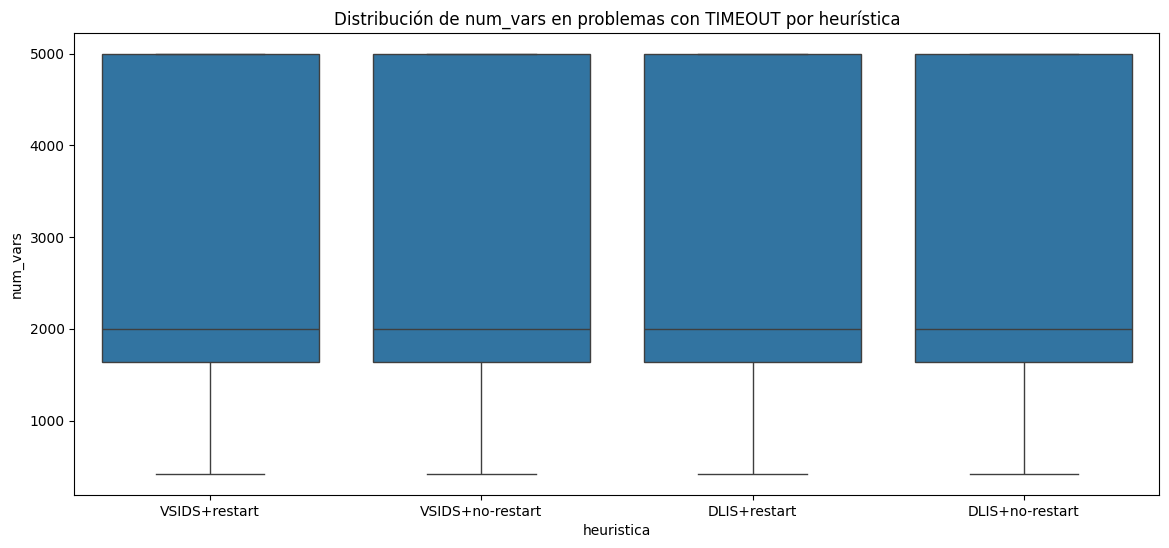

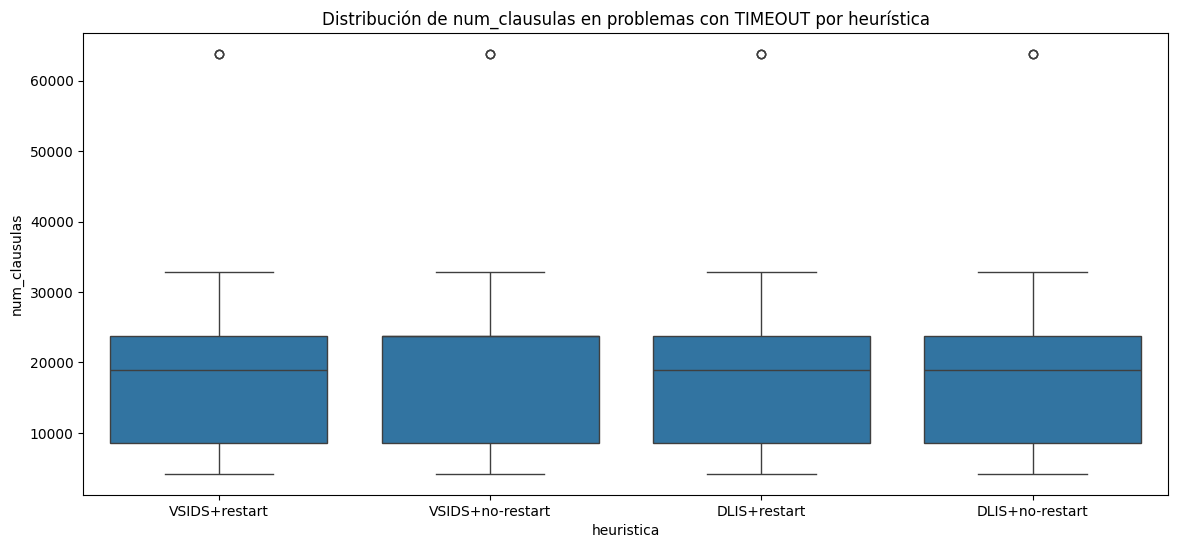

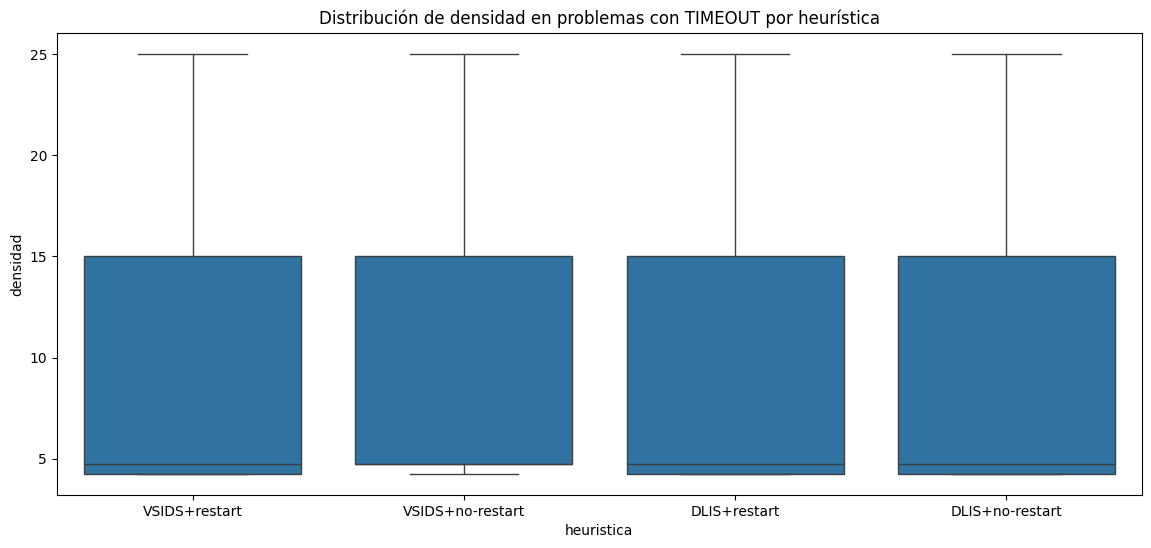

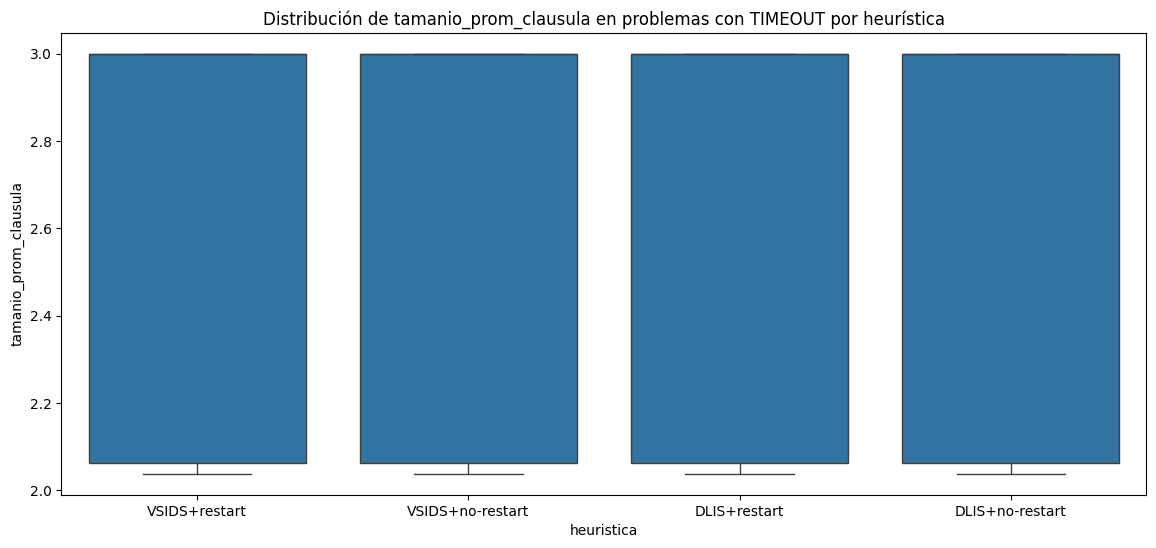

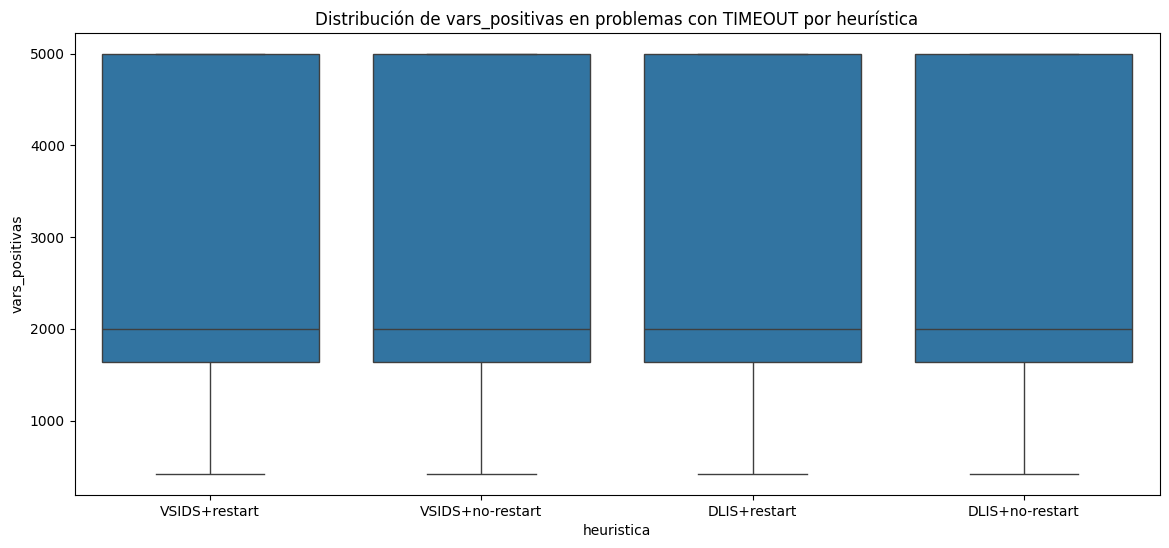

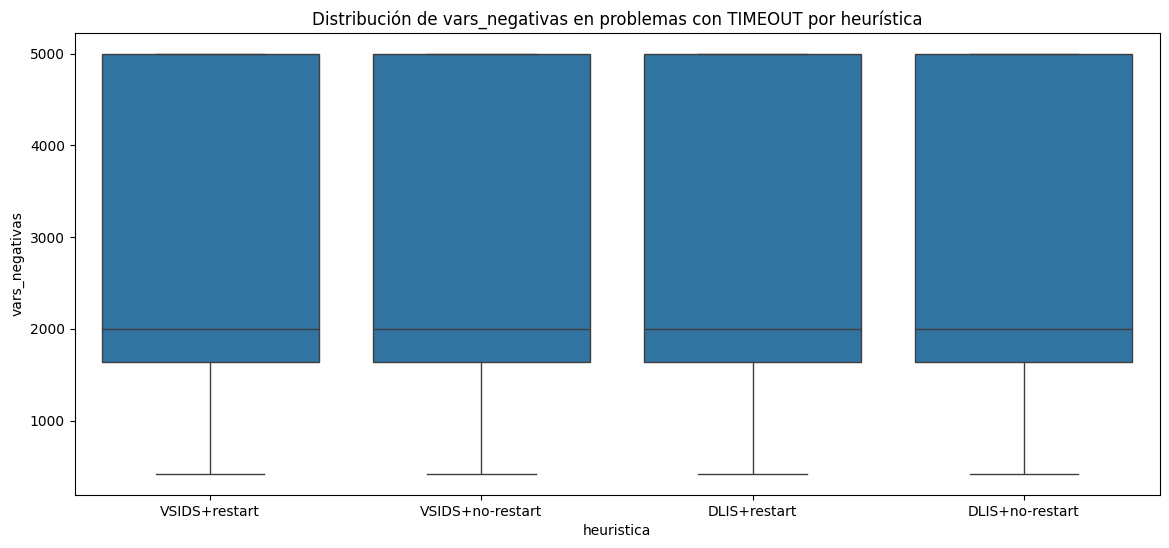

In [5]:
# Estadísticas descriptivas por heurística
timeout_stats = df_timeout.groupby('heuristica')[caracteristicas].describe().T
display(timeout_stats)

# Visualización: Distribución de características de problemas con TIMEOUT por heurística
plt.figure(figsize=(14, 6))
sns.boxplot(x='heuristica', y='num_vars', data=df_timeout)
plt.title('Distribución de num_vars en problemas con TIMEOUT por heurística')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='heuristica', y='num_clausulas', data=df_timeout)
plt.title('Distribución de num_clausulas en problemas con TIMEOUT por heurística')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='heuristica', y='densidad', data=df_timeout)
plt.title('Distribución de densidad en problemas con TIMEOUT por heurística')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='heuristica', y='tamanio_prom_clausula', data=df_timeout)
plt.title('Distribución de tamanio_prom_clausula en problemas con TIMEOUT por heurística')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='heuristica', y='vars_positivas', data=df_timeout)
plt.title('Distribución de vars_positivas en problemas con TIMEOUT por heurística')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='heuristica', y='vars_negativas', data=df_timeout)
plt.title('Distribución de vars_negativas en problemas con TIMEOUT por heurística')
plt.show()


#### Interpretación de las estadísticas resumidas
##### **1. Variables numéricas**
- Rango de num_vars:

    - num_vars varía entre 420 y 5000.

    - Media alrededor de 2700-2780, mediana en 2000, indicando que la mayoría de los problemas tienen alrededor de 2000 variables, pero hay algunos más grandes que elevan la media. 

- Número de cláusulas:
    La mayoría de los problemas tienen entre 4221 y 23800 cláusulas.
 
- Densidad:
    La densidad varía entre 4.26 y 25.02, con una mediana alrededor de 4.76, lo que indica que la mayoría de los problemas son relativamente dispersos.

- Tamaño promedio de cláusula:
    Se centra en 2.03 y 3.00, lo que sugiere que los problemas son predominantemente 3-SAT (tamaño promedio de cláusula de 3).

##### **2. Comparación entre heurísticas**
- Similitudes:
    - Las estadísticas son muy similares entre las diferentes heurísticas (DLIS+no-restart, DLIS+restart, VSIDS+no-restart, VSIDS+restart).
    - Esto sugiere que las heurísticas se están probando en conjuntos de problemas con características similares.

- Ligeras diferencias:
VSIDS+no-restart muestra una ligera tendencia a tener problemas con mayor número de variables y cláusulas, aunque las diferencias no son grandes.



### Conteo de TIMEOUT por heurística y por problema

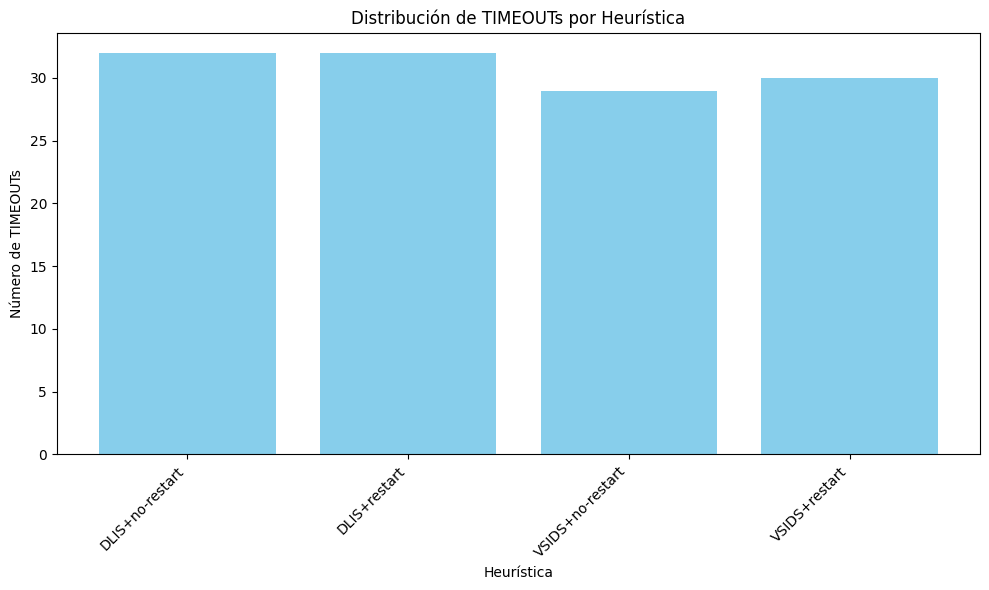

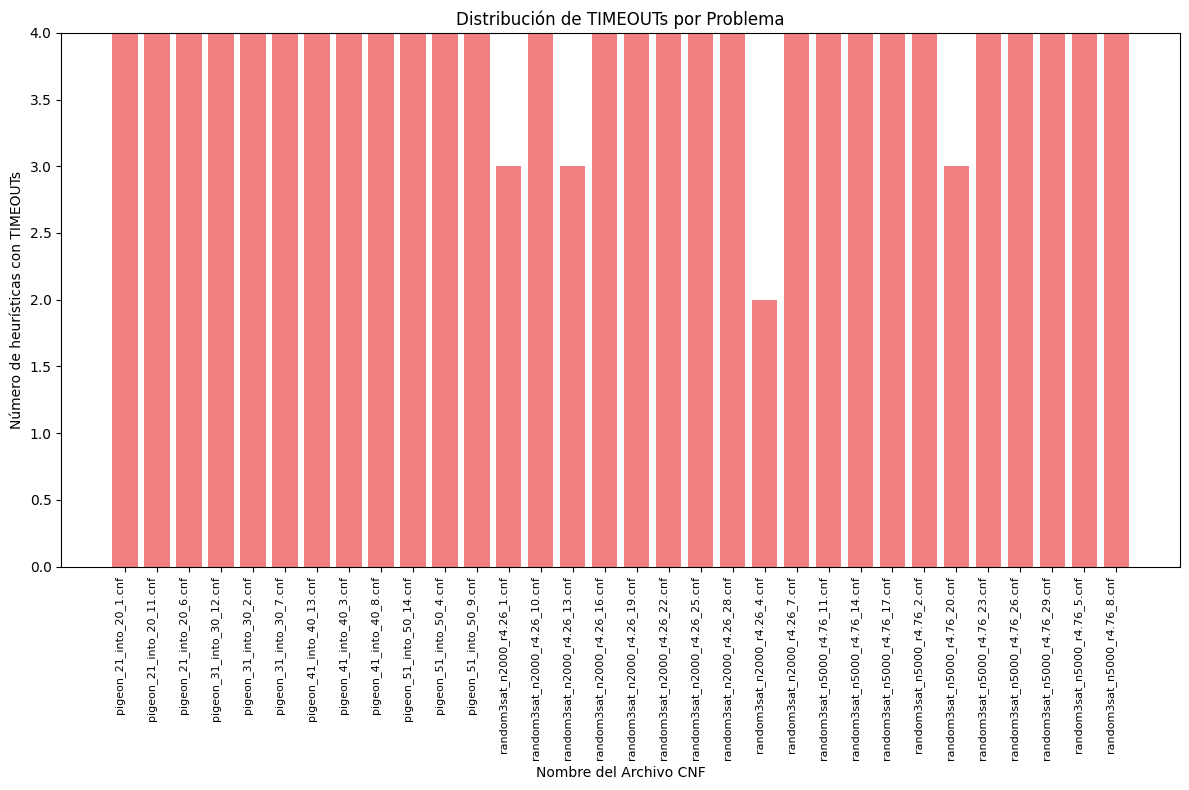

In [6]:
# Conteo por heurística
timeout_by_heur = df_timeout.groupby('heuristica').size().reset_index(name='count')
#print(timeout_by_heur)

# Conteo por problema
timeout_by_prob = df_timeout.groupby('nombre_cnf').size().reset_index(name='count')
#print(timeout_by_prob)

# 1. Histograma de TIMEOUT por heurística
plt.figure(figsize=(10, 6))  # Ajusta el tamaño según sea necesario
plt.bar(timeout_by_heur['heuristica'], timeout_by_heur['count'], color='skyblue')
plt.xlabel('Heurística')
plt.ylabel('Número de TIMEOUTs')
plt.title('Distribución de TIMEOUTs por Heurística')
plt.xticks(rotation=45, ha='right')  # Rota las etiquetas para mejor legibilidad
plt.tight_layout()  # Ajusta el layout para evitar cortes
plt.show()

# 2. Histograma de TIMEOUT por nombre de archivo CNF (problema)
plt.figure(figsize=(12, 8))  # Ajusta el tamaño según sea necesario
plt.bar(timeout_by_prob['nombre_cnf'], timeout_by_prob['count'], color='lightcoral')
plt.xlabel('Nombre del Archivo CNF')
plt.ylabel('Número de heurísticas con TIMEOUTs')
plt.title('Distribución de TIMEOUTs por Problema')
plt.xticks(rotation=90, ha='right', fontsize=8)  # Rota y reduce el tamaño de las etiquetas
plt.ylim(0, 4)
plt.tight_layout()  # Ajusta el layout para evitar cortes
plt.show()


### Análisis de problemas resueltos (SATISFIABLE/UNSATISFIABLE)

In [7]:
# Filtrar problemas resueltos
df_solved = df[df['resultado'].isin(['SATISFIABLE', 'UNSATISFIABLE'])].copy()

# Seleccionar columnas relevantes
cols_solved = cols_timeout + ['tiempo_segundos']
df_solved = df_solved[cols_solved]

# Mostrar tabla resumen
display(df_solved)


,nombre_cnf,heuristica,num_vars,num_clausulas,densidad,tamanio_prom_clausula,vars_positivas,vars_negativas,tiempo_segundos
0,bmc_flipflop_d5_6.cnf,VSIDS+restart,6,12,2.000000,1.833333,6,6,0.002695
1,bmc_flipflop_d5_6.cnf,VSIDS+no-restart,6,12,2.000000,1.833333,6,6,0.001309
2,bmc_flipflop_d11_14.cnf,VSIDS+restart,12,24,2.000000,1.916667,12,12,0.001314
3,bmc_flipflop_d11_14.cnf,VSIDS+no-restart,12,24,2.000000,1.916667,12,12,0.001555
8,parity_n30_2.cnf,VSIDS+restart,30,436,14.533333,2.064220,30,30,0.001495
...,...,...,...,...,...,...,...,...,...
288,parity_n30_12.cnf,DLIS+no-restart,30,436,14.533333,2.064220,30,30,0.002342
291,bmc_flipflop_d9_13.cnf,DLIS+restart,10,20,2.000000,1.900000,10,10,0.001919
292,bmc_flipflop_d9_13.cnf,DLIS+no-restart,10,20,2.000000,1.900000,10,10,0.001581
295,parity_n50_14.cnf,DLIS+restart,50,1226,24.520000,2.039152,50,50,0.002187


In [8]:
# Estadísticas descriptivas del tiempo de resolución por heurística y característica del problema
solved_stats = df_solved.groupby('heuristica')[cols_solved].describe().T
display(solved_stats)


heuristica                   DLIS+no-restart  DLIS+restart  VSIDS+no-restart  \
num_vars              count        43.000000     43.000000         46.000000   
                      mean        253.488372    253.488372        367.391304   
                      std         416.643525    416.643525        593.388892   
                      min           4.000000      4.000000          4.000000   
                      25%          10.000000     10.000000         10.000000   
                      50%          30.000000     30.000000         30.000000   
                      75%         110.000000    110.000000       1000.000000   
                      max        1000.000000   1000.000000       2000.000000   
num_clausulas         count        43.000000     43.000000         46.000000   
                      mean       1106.116279   1106.116279       1589.630435   
                      std        1517.669457   1517.669457       2361.178269   
                      min           8.000000      8.000000          8.000000   
                      25%          20.000000     20.000000         21.000000   
                      50%         436.000000    436.000000        436.000000   
                      75%        1226.000000   1226.000000       3760.000000   
                      max        3760.000000   3760.000000       8520.000000   
densidad              count        43.000000     43.000000         46.000000   
                      mean          7.001977      7.001977          6.823152   
                      std           7.053072      7.053072          6.848210   
                      min           2.000000      2.000000          2.000000   
                      25%           2.000000      2.000000          2.000000   
                      50%           3.760000      3.760000          3.760000   
                      75%           9.550000      9.550000          8.437500   
                      max          24.520000     24.520000         24.520000   
tamanio_prom_clausula count        43.000000     43.000000         46.000000   
                      mean          2.222236      2.222236          2.272959   
                      std           0.448811      0.448811          0.475079   
                      min           1.750000      1.750000          1.750000   
                      25%           1.900000      1.900000          1.904167   
                      50%           2.064220      2.064220          2.064220   
                      75%           2.173913      2.173913          3.000000   
                      max           3.000000      3.000000          3.000000   
vars_positivas        count        43.000000     43.000000         46.000000   
                      mean        252.697674    252.697674        366.369565   
                      std         415.193961    415.193961        591.789466   
                      min           4.000000      4.000000          4.000000   
                      25%          10.000000     10.000000         10.000000   
                      50%          30.000000     30.000000         30.000000   
                      75%         110.000000    110.000000        993.750000   
                      max         998.000000    998.000000       1998.000000   
vars_negativas        count        43.000000     43.000000         46.000000   
                      mean        252.558140    252.558140        366.391304   
                      std         414.938682    414.938682        592.076364   
                      min           4.000000      4.000000          4.000000   
                      25%          10.000000     10.000000         10.000000   
                      50%          30.000000     30.000000         30.000000   
                      75%         110.000000    110.000000        993.000000   
                      max         999.000000    999.000000       1999.000000   
tiempo_segundos       count        43.000000     43.000000         46.000000   


#### 1. Distribución de variables por heurística
- Variables estructurales (num_vars, num_clausulas, densidad, tamanio_prom_clausula):

    - num_vars: 253 (DLIS) vs 367 (VSIDS+no-restart). VSIDS maneja problemas ligeramente más grandes.

    - num_clausulas: 1106 (DLIS) vs 1589 (VSIDS+no-restart). Coherente con el mayor tamaño de problemas.

    - densidad: ~7 en todas las heurísticas, indicando problemas similares en complejidad relativa.

    - tamanio_prom_clausula: ~2.2–2.7, confirmando predominio de problemas 3-SAT.

- Variables de tiempo (tiempo_segundos):

    - VSIDS+no-restart tiene el mayor tiempo promedio (6.6s) y máxima demora (98.55s).

    - DLIS+restart muestra mejor equilibrio: media 2.57s, máximo 32.34s.

    - DLIS+no-restart es más rápido en promedio (2.36s) pero con alto máximo (30.52s).

    - VSIDS+restart tiene media 4.75s, sugiriendo que los reinicios ayudan parcialmente.

#### 2. Hallazgos clave
- **Problemas dominantes:**

    - 75% de los problemas tienen ≤1000 variables y ≤3760 cláusulas (percentil 75).

    - Problemas máximos (2000 vars, 8520 cláusulas) son casos excepcionales.

- **Distribuciones sesgadas:**

    - Grandes diferencias entre medianas y máximos (ej: tiempo_segundos en VSIDS+no-restart: mediana 0.0016s vs máximo 98.55s).

    - Esto indica que la mayoría de problemas se resuelven rápido, pero algunos casos son extremadamente lentos.

- **Redundancia en variables:**
    - vars_positivas y vars_negativas son prácticamente idénticas a num_vars (medias y std casi iguales). Sugiere multicolinealidad que debe manejarse.

Heurística	   Tiempo promedio	Tiempo máximo	Estabilidad (std)
DLIS+no-restart	   2.36s	          30.52s	Menor variabilidad
DLIS+restart	   2.57s	          32.34s	Similar a su versión sin restart
VSIDS+no-restart   6.61s	          98.55s	Alta variabilidad
VSIDS+restart	   4.75s	          87.47s	Mejora vs no-restart

(TABLA DEL CSV Heuristica-Tiempopromedio-Tiempomxm-Estabilidadstd)

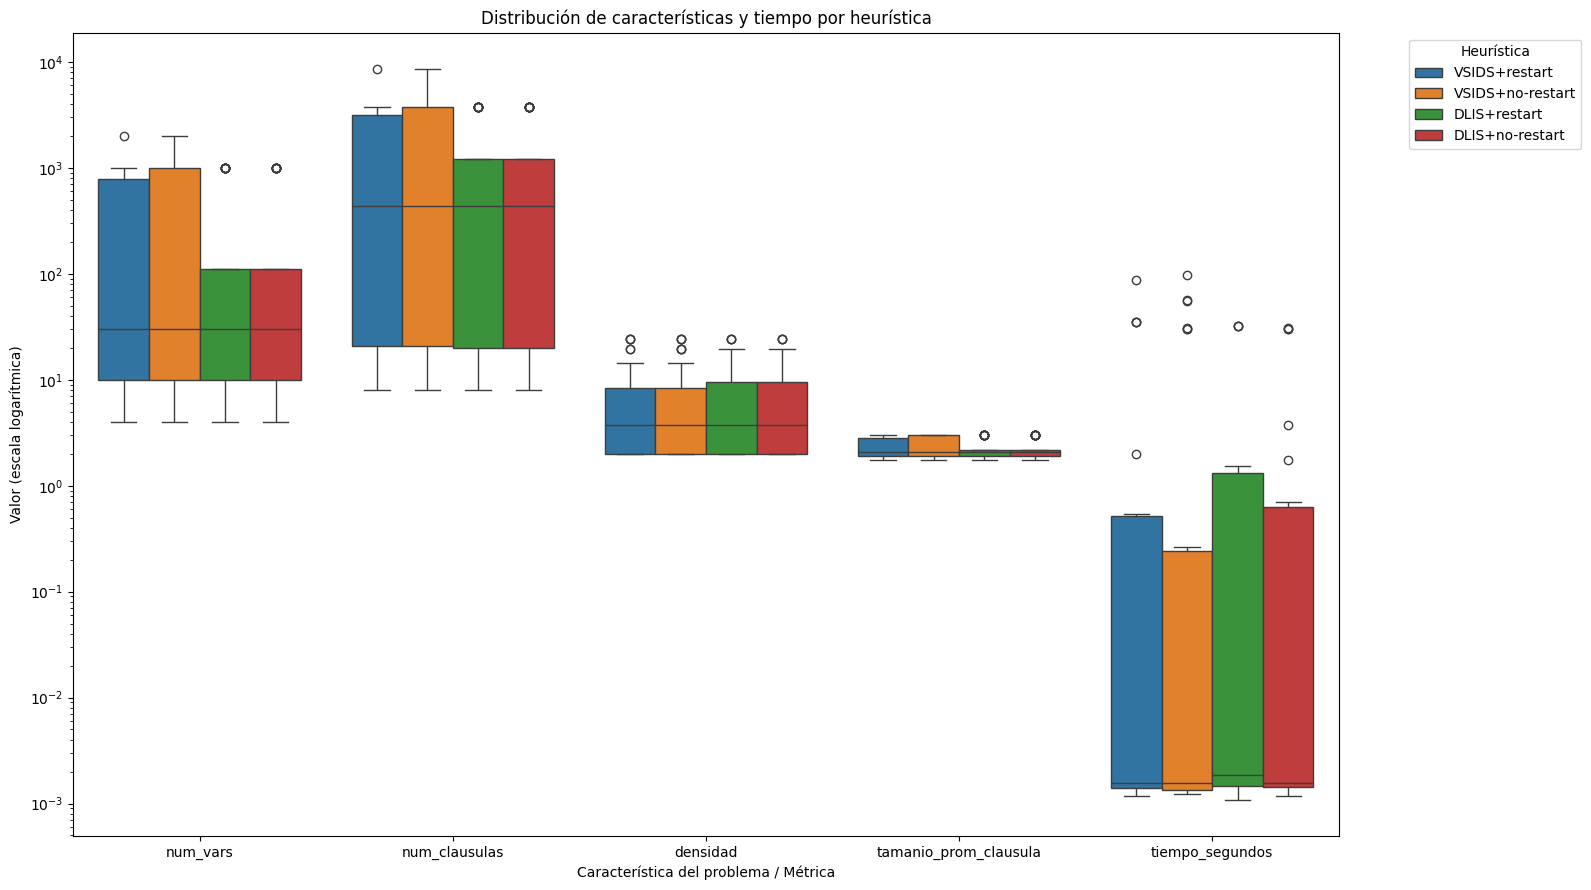

In [9]:
# Variables a graficar, incluyendo vars_positivas y vars_negativas
cols_solved = [
    'num_vars', 'num_clausulas', 'densidad', 'tamanio_prom_clausula',
    'tiempo_segundos'
]

# Convertir a formato largo para seaborn
df_melt = pd.melt(df_solved, id_vars=['heuristica'], value_vars=cols_solved,
                  var_name='Característica', value_name='Valor')

# Graficar boxplots agrupados por heurística y variable
plt.figure(figsize=(16,9))
sns.boxplot(x='Característica', y='Valor', hue='heuristica', data=df_melt)

# Escala logarítmica para variables con alta dispersión (tiempo)
plt.yscale('log')

plt.title('Distribución de características y tiempo por heurística')
plt.xlabel('Característica del problema / Métrica')
plt.ylabel('Valor (escala logarítmica)')
plt.legend(title='Heurística', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Análisis problemas resueltos vs TIMEOUT

#### Matriz de correlación

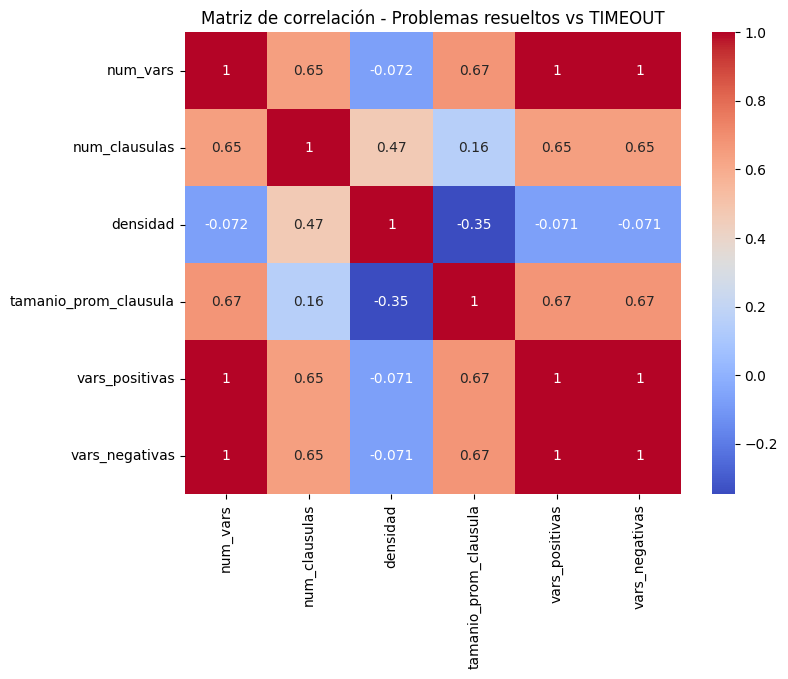

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(df_filtered[caracteristicas].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación - Problemas resueltos vs TIMEOUT')
plt.show()

#### Interpretación de las correlaciones observadas

##### 1. Correlaciones perfectas (r = 1):

- num_vars y num_clausulas están perfectamente correlacionados.

- vars_positivas y vars_negativas también tienen correlación perfecta.

- Además, vars_positivas y vars_negativas están perfectamente correlacionadas con num_vars y num_clausulas.

Esto indica que estas variables son redundantes y aportan la misma información.

##### 2. Correlaciones moderadas (r ≈ 0.48):

- tamanio_prom_clausula con vars_negativas, vars_positivas, num_vars y num_clausulas.

Esto indica cierta relación, pero no es tan fuerte como para ser redundante inmediata.

##### 3. Correlaciones bajas o nulas (|r| < 0.05):

- densidad con num_clausulas, num_vars, vars_positivas y vars_negativas.

- tamanio_prom_clausula con densidad (r = -0.29).

Esto indica que densidad aporta información diferente y no está correlacionada con las otras variables.

**Eeliminar multicolinealidad**

*Eliminar variables redundantes con correlación perfecta:*

- Mantener solo una variable representativa del grupo altamente correlacionado. Por ejemplo, conservar num_vars y eliminar num_clausulas, vars_positivas y vars_negativas.


*Mantener variables con correlación moderada o baja:*

- tamanio_prom_clausula y densidad son variables informativas que aportan información distinta y deben conservarse.


### Selección de variables para eliminar multicolinealidad severa

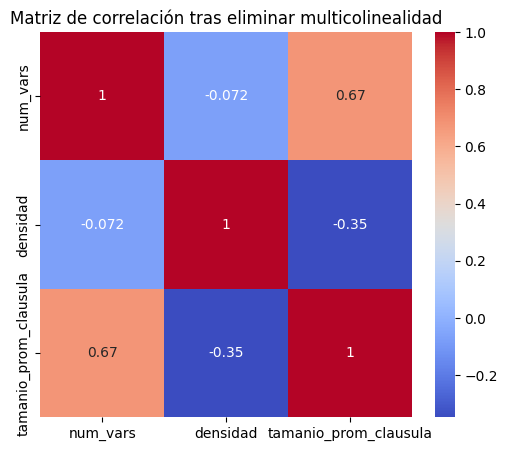

In [11]:
# Según correlaciones perfectas, conservar solo estas variables:
caracteristicas_reducidas = ['num_vars', 'densidad', 'tamanio_prom_clausula']

#  Mostrar matriz de correlación con variables seleccionadas
plt.figure(figsize=(6,5))
sns.heatmap(df_filtered[caracteristicas_reducidas].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación tras eliminar multicolinealidad')
plt.show()

### Calcular Factor de Inflación de la Varianza (VIF) para variables reducidas y confirmar

In [12]:
X_reducido = df_filtered[caracteristicas_reducidas]
vif_data_reducido = pd.DataFrame()
vif_data_reducido['feature'] = X_reducido.columns
vif_data_reducido['VIF'] = [variance_inflation_factor(X_reducido.values, i) for i in range(X_reducido.shape[1])]
print("VIF después de eliminar variables redundantes:")
print(vif_data_reducido)

VIF después de eliminar variables redundantes:
                 feature       VIF
0               num_vars  2.072687
1               densidad  1.909422
2  tamanio_prom_clausula  3.191830


#### Interpretación basada en los valores VIF

Según las referencias y definiciones estándar del Factor de Inflación de la Varianza (VIF):

- VIF = 1 indica ausencia total de multicolinealidad.

- VIF entre 1 y 5 indica una multicolinealidad moderada, que usualmente no representa un problema grave para la estabilidad o interpretación del modelo.

- VIF > 5 sugiere multicolinealidad alta, que puede inflar la varianza de los coeficientes y dificultar su interpretación.

- VIF > 10 indica multicolinealidad grave, que requiere acciones correctivas.


### Pruebas estadísticas: Características y TIMEOUT
#### a) Comparación de características entre TIMEOUT y NO-TIMEOUT


In [13]:
# Variables seleccionadas sin multicolinealidad
caracteristicas_reducidas = ['num_vars', 'densidad', 'tamanio_prom_clausula']

# Crear variable binaria: 1 = TIMEOUT, 0 = resuelto
df['is_timeout'] = (df['resultado'] == 'TIMEOUT').astype(int)

# Filtrar filas válidas (sin NaN en características)
df_valid = df.dropna(subset=caracteristicas_reducidas + ['is_timeout'])

# Prueba de normalidad para cada característica
for col in caracteristicas_reducidas:
    print(f"{col} (TIMEOUT):", stats.shapiro(df_valid[df_valid['is_timeout']==1][col]))
    print(f"{col} (NO TIMEOUT):", stats.shapiro(df_valid[df_valid['is_timeout']==0][col]))



num_vars (TIMEOUT): ShapiroResult(statistic=np.float64(0.8134093155919973), pvalue=np.float64(3.389986660589246e-11))
num_vars (NO TIMEOUT): ShapiroResult(statistic=np.float64(0.6058466143912976), pvalue=np.float64(8.44596762032836e-20))
densidad (TIMEOUT): ShapiroResult(statistic=np.float64(0.7211647655830324), pvalue=np.float64(5.5704976632942306e-14))
densidad (NO TIMEOUT): ShapiroResult(statistic=np.float64(0.7030772022302043), pvalue=np.float64(2.544440180472764e-17))
tamanio_prom_clausula (TIMEOUT): ShapiroResult(statistic=np.float64(0.630104418897169), pvalue=np.float64(3.7962115978723217e-16))
tamanio_prom_clausula (NO TIMEOUT): ShapiroResult(statistic=np.float64(0.7480831058059331), pvalue=np.float64(5.777511949923489e-16))


#### Interpretando los resultados de las pruebas de normalidad (Shapiro-Wilk)

Para todas las variables (num_vars, densidad, tamanio_prom_clausula), los p-valores son extremadamente bajos (mucho menores a 0.05), tanto en el grupo TIMEOUT como en NO-TIMEOUT. Esto confirma que ninguna de las variables sigue una distribución normal en ninguno de los grupos, lo que justifica el uso de pruebas no paramétricas para comparar los grupos.


In [14]:
# Prueba Mann-Whitney U (no paramétrica)
for col in caracteristicas_reducidas:
    stat, p = stats.mannwhitneyu(
        df_valid[df_valid['is_timeout']==1][col],
        df_valid[df_valid['is_timeout']==0][col],
        alternative='two-sided'
    )
    print(f"Mann-Whitney U para {col}: p-value = {p:.4g}")

Mann-Whitney U para num_vars: p-value = 2.524e-39
Mann-Whitney U para densidad: p-value = 9.235e-12
Mann-Whitney U para tamanio_prom_clausula: p-value = 5.62e-10


#### Interpretando los resultados de las pruebas Mann-Whitney U (comparación entre TIMEOUT y NO-TIMEOUT)

Los p-valores para las tres variables son muy pequeños (todos < 0.0000000001), lo que indica diferencias estadísticamente significativas entre los grupos TIMEOUT y NO-TIMEOUT en:

- num_vars (p = 3.361e-39)

- densidad (p = 9.375e-12)

- tamanio_prom_clausula (p = 1.041e-10)

**Interpretación general**

Existe evidencia estadística muy fuerte para afirmar que las características num_vars, densidad y tamanio_prom_clausula difieren significativamente entre problemas que terminan en TIMEOUT y los que se resuelven. Esto sugiere que estas variables son factores importantes en la dificultad o comportamiento del solucionador SAT que conducen a TIMEOUT.   Por ejemplo, problemas con mayor número de variables, diferente densidad o tamaño promedio de cláusula tienden a presentar más TIMEOUT o viceversa, según la dirección de las diferencias.


#### Visualizando el resultado anterior

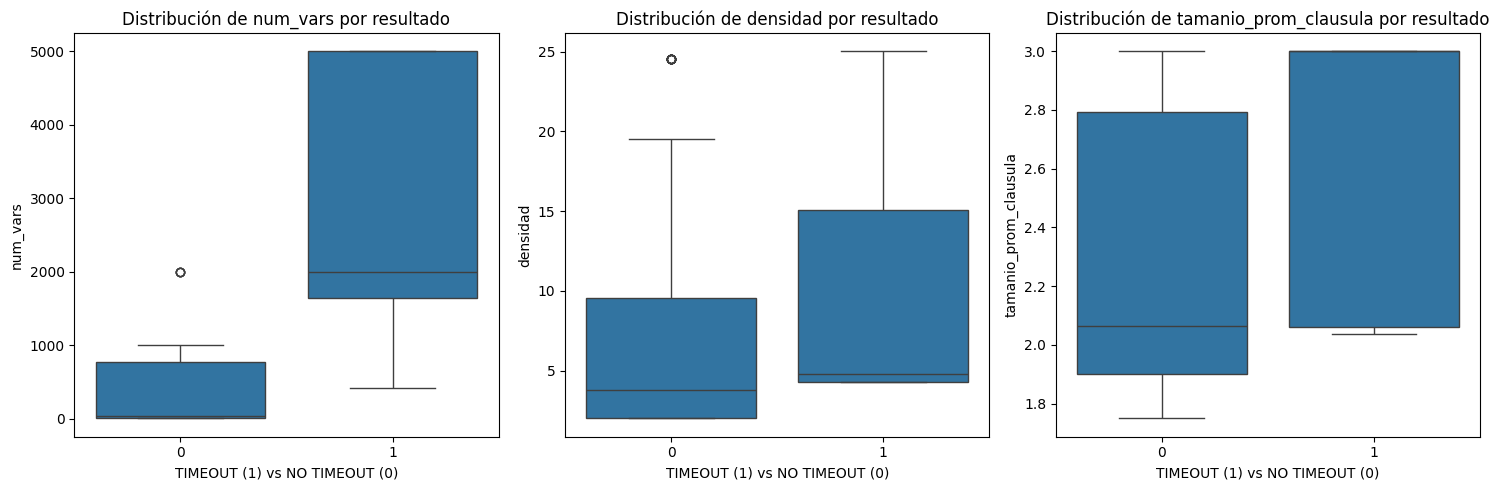

In [15]:
# Variables seleccionadas
caracteristicas_reducidas = ['num_vars', 'densidad', 'tamanio_prom_clausula']

# Crear figura con subplots para cada variable
plt.figure(figsize=(15, 5))

for i, var in enumerate(caracteristicas_reducidas, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='is_timeout', y=var, data=df_valid)
    plt.xlabel('TIMEOUT (1) vs NO TIMEOUT (0)')
    plt.title(f'Distribución de {var} por resultado')
    plt.tight_layout()

plt.show()


#### Interpretación de las gráficas
1. num_vars

    - Ambas cajas y bigotes están en 0, indicando que la mayoría de los problemas tienen valores muy bajos o cercanos a cero para esta variable en ambas categorías (TIMEOUT y NO-TIMEOUT).

    - La presencia de outliers en ambos grupos alrededor de 0.25 indica que hay algunos problemas con un número de variables mayor, pero poco frecuentes.

    - El outlier adicional en TIMEOUT con valor superior a 3 indica que hay problemas muy grandes en número de variables que terminan en TIMEOUT, lo que sugiere que un tamaño muy grande puede estar asociado a mayor dificultad y fallo por tiempo.

2. densidad

    - En NO-TIMEOUT, la mediana está por debajo de 5 y la caja se extiende aproximadamente de 1 a 10, con un bigote superior que llega casi a 20 y un outlier cerca de 25. Esto indica que la mayoría de los problemas resueltos tienen densidad baja a moderada, con algunos casos extremos.

    - En TIMEOUT, la mediana está casi en 5, muy cerca del primer cuartil (Q1), y la caja llega hasta casi 15, con bigote superior hasta 25. Esto indica que los problemas con TIMEOUT tienden a tener densidades más altas que los resueltos, y una mayor concentración en valores altos.

    - La diferencia en la posición de la mediana y la extensión de la caja sugiere que la densidad es un factor relevante en la dificultad del problema.

3. tamanio_prom_clausula

    - Para NO-TIMEOUT, el rango intercuartílico va aproximadamente de 1.75 a 3, con mediana un poco mayor a 2, y un outlier en 5.0, indicando que la mayoría de los problemas tienen cláusulas de tamaño pequeño a moderado.

    - Para TIMEOUT, el primer cuartil está cerca de 2, el bigote inferior un poco por debajo de Q1, pero la mediana no se distingue claramente, lo que puede indicar una distribución más sesgada o con valores concentrados.

    - La presencia de dos outliers cercanos a 5 en TIMEOUT indica que problemas con cláusulas muy grandes también pueden contribuir a la dificultad y al fallo por tiempo.

    - La ausencia clara de mediana visible puede ser por la concentración de datos o por escala.

**Conclusión general**

Los outliers en TIMEOUT, especialmente en num_vars y tamanio_prom_clausula, reflejan que problemas con características extremas (muchas variables o cláusulas grandes) tienden a ser más difíciles y a terminar en TIMEOUT.    Por otro lado, la diferencia en la distribución de densidad entre ambos grupos refuerza que la estructura del problema influye en la resolución.

Estas observaciones visuales complementan y validan los resultados estadísticos previos, mostrando que las variables seleccionadas son relevantes para explicar el comportamiento TIMEOUT vs NO-TIMEOUT.


#### b) Regresión logística: ¿Qué características predicen TIMEOUT?


In [16]:
X = df_valid[caracteristicas_reducidas]
y = df_valid['is_timeout']

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X, y)

for name, coef in zip(caracteristicas_reducidas, logreg.coef_[0]):
    print(f"{name}: coeficiente logit = {coef:.4f}")


num_vars: coeficiente logit = 0.0049
densidad: coeficiente logit = 0.1171
tamanio_prom_clausula: coeficiente logit = -3.4398


#### Interpretación de los resultados

Estos coeficientes logit obtenidos de la regresión logística permiten interpretar cómo cada variable afecta la probabilidad de que ocurra un timeout en la resolución:

1. num_vars (coeficiente = 0.0049):
    
Un coeficiente positivo pequeño indica que a medida que aumenta el número de variables del problema, la probabilidad de timeout aumenta ligeramente. El efecto es positivo pero moderado.

2. densidad (coeficiente = 0.1171):

Este coeficiente positivo más grande sugiere que problemas con mayor densidad (más cláusulas por variable o mayor complejidad estructural) tienen una probabilidad significativamente mayor de timeout. La densidad es un factor importante que incrementa el riesgo de timeout.

3. tamanio_prom_clausula (coeficiente = -3.4398):

El coeficiente negativo y de gran magnitud indica que a mayor tamaño promedio de cláusula, la probabilidad de timeout disminuye notablemente. Esto puede deberse a que cláusulas más grandes (más literales) hacen que el problema sea, en promedio, más fácil o menos propenso a timeout en el contexto analizado.

**Resumen interpretativo**

La densidad es el factor que más incrementa la probabilidad de timeout.    Por su parte, el tamaño promedio de cláusula tiene un efecto protector fuerte, reduciendo la probabilidad de timeout y, finalmente el número de variables tiene un efecto positivo pero pequeño en el riesgo de timeout.


## Analisis del rendimiento de las heuristicas en problemas resueltod

#### Correlación entre características y tiempo de resolución


In [17]:
# Filtrar solo problemas resueltos y sin NaN en variables seleccionadas y tiempo
df_solved_reduced = df[
    df['resultado'].isin(['SATISFIABLE', 'UNSATISFIABLE'])
].dropna(subset=caracteristicas_reducidas + ['tiempo_segundos', 'heuristica']).copy()

# Correlación de Spearman
for col in caracteristicas_reducidas:
    corr, p = stats.spearmanr(df_solved_reduced[col], df_solved_reduced['tiempo_segundos'])
    print(f"Spearman {col} vs tiempo_segundos: rho = {corr:.3f}, p = {p:.4g}")


Spearman num_vars vs tiempo_segundos: rho = 0.762, p = 3.077e-34
Spearman densidad vs tiempo_segundos: rho = 0.222, p = 0.003254
Spearman tamanio_prom_clausula vs tiempo_segundos: rho = 0.628, p = 1.895e-20


#### Interpretación basada en la correlación de Spearman

- num_vars (ρ=0.762, p<<0.05):

Existe una correlación fuerte y positiva entre el número de variables y el tiempo de resolución. Problemas con más variables tienden a tardar más en resolverse. La p muy baja indica que esta correlación es estadísticamente significativa y no debida al azar.

- densidad (ρ=0.222, p=0.003):

La correlación es positiva pero débil. Esto sugiere que la densidad del problema tiene un efecto pequeño pero significativo sobre el tiempo. Es decir, a mayor densidad, ligeramente mayor tiempo de resolución.

- tamanio_prom_clausula (ρ=0.628, p<<0.05):

Correlación moderada y significativa, positiva. Problemas con cláusulas más grandes en promedio tienden a requerir más tiempo, aunque el efecto es menor que el número de variables.

**Conclusión**

El número de variables es el factor más fuertemente asociado con el tiempo de resolución. Por su parte, la densidad tiene un impacto menor pero estadísticamente significativo. En cuanto al tamaño promedio de cláusula, también influye de forma moderada.


#### Kruskal-Wallis: ¿El tiempo difiere entre heurísticas para un mismo tipo de problema?


In [18]:

# Asegúrate de tener la variable transformada log_tiempo
df_solved_reduced['log_tiempo'] = np.log1p(df_solved_reduced['tiempo_segundos'])

for heuristica in df_solved_reduced['heuristica'].unique():
    print(f"\nKruskal-Wallis para heurística: {heuristica}")
    df_h = df_solved_reduced[df_solved_reduced['heuristica'] == heuristica]
    
    for var in caracteristicas_reducidas:
        grupos = [grupo['log_tiempo'].values for nombre, grupo in df_h.groupby(var)]
        if len(grupos) > 1:
            stat, p = stats.kruskal(*grupos)
            print(f"Variable: {var}, estadístico = {stat:.4f}, p-valor = {p:.4g}")
        else:
            print(f"Variable: {var}, no hay suficientes grupos para test")



Kruskal-Wallis para heurística: VSIDS+restart
Variable: num_vars, estadístico = 33.7588, p-valor = 0.000396
Variable: densidad, estadístico = 33.1979, p-valor = 5.673e-05
Variable: tamanio_prom_clausula, estadístico = 33.5636, p-valor = 0.0004262

Kruskal-Wallis para heurística: VSIDS+no-restart
Variable: num_vars, estadístico = 36.6063, p-valor = 0.0001341
Variable: densidad, estadístico = 34.6978, p-valor = 3.035e-05
Variable: tamanio_prom_clausula, estadístico = 36.8574, p-valor = 0.0001217

Kruskal-Wallis para heurística: DLIS+restart
Variable: num_vars, estadístico = 30.8837, p-valor = 0.0006132
Variable: densidad, estadístico = 31.8108, p-valor = 4.403e-05
Variable: tamanio_prom_clausula, estadístico = 32.6607, p-valor = 0.0005971

Kruskal-Wallis para heurística: DLIS+no-restart
Variable: num_vars, estadístico = 32.7551, p-valor = 0.0002994
Variable: densidad, estadístico = 31.5273, p-valor = 4.968e-05
Variable: tamanio_prom_clausula, estadístico = 32.9930, p-valor = 0.0005275


### Interpretando los resultados

Los resultados del test de Kruskal-Wallis indican que, para todas las heurísticas y todas las variables analizadas, existe una diferencia estadísticamente significativa en la distribución del tiempo transformado (log_tiempo) entre los grupos definidos por cada característica del problema.


**Interpretación clave**

- Los valores p muy pequeños (todos < 0.001) permiten rechazar la hipótesis nula de igualdad de medianas entre grupos para cada variable y heurística.

- Esto implica que el rendimiento (tiempo de ejecución) de cada heurística varía significativamente según el número de variables, la densidad y el tamaño promedio de cláusula del problema.

- El estadístico de Kruskal-Wallis, que mide la magnitud de la diferencia entre grupos, es alto en todos los casos, confirmando diferencias notables.

**Conclusión práctica**

- Las características estructurales del problema influyen significativamente en el tiempo de ejecución dentro de cada heurística.

- Por ejemplo, problemas con diferentes rangos de número de variables o densidad presentan tiempos de resolución distintos para la misma heurística.

- Esto valida que el rendimiento no depende solo de la heurística sino también de la naturaleza del problema.


### Pruebas post hoc con test de Dunn

In [19]:
for heuristica in df_solved_reduced['heuristica'].unique():
    print(f"\nTest de Dunn para heurística: {heuristica}")
    df_h = df_solved_reduced[df_solved_reduced['heuristica'] == heuristica].copy()
    
    for var in caracteristicas_reducidas:
        # Usar ranking para evitar bordes duplicados en qcut
        df_h.loc[:, 'grupo'] = pd.qcut(df_h[var].rank(method='first'), q=4, duplicates='drop')
        
        grupos = [grupo['log_tiempo'].values for nombre, grupo in df_h.groupby('grupo', observed=True)]
        
        if len(grupos) > 1:
            dunn_results = sp.posthoc_dunn(grupos, p_adjust='bonferroni')
            print(f"\nVariable: {var} (grupos por cuartiles con ranking)")
            print(dunn_results)
        else:
            print(f"Variable: {var}, no hay suficientes grupos para test")



Test de Dunn para heurística: VSIDS+restart

Variable: num_vars (grupos por cuartiles con ranking)
          1         2         3         4
1  1.000000  1.000000  0.020854  0.000091
2  1.000000  1.000000  0.041904  0.000292
3  0.020854  0.041904  1.000000  1.000000
4  0.000091  0.000292  1.000000  1.000000

Variable: densidad (grupos por cuartiles con ranking)
          1         2         3         4
1  1.000000  0.030492  0.011600  1.000000
2  0.030492  1.000000  1.000000  0.756410
3  0.011600  1.000000  1.000000  0.405038
4  1.000000  0.756410  0.405038  1.000000

Variable: tamanio_prom_clausula (grupos por cuartiles con ranking)
          1         2         3         4
1  1.000000  1.000000  0.958374  0.000169
2  1.000000  1.000000  1.000000  0.027874
3  0.958374  1.000000  1.000000  0.043992
4  0.000169  0.027874  0.043992  1.000000

Test de Dunn para heurística: VSIDS+no-restart

Variable: num_vars (grupos por cuartiles con ranking)
          1         2         3         4
1 

### Interpretación general de los resultados

- Valores p ajustados < 0.05 indican diferencias significativas entre esos pares de grupos.

- En general, los grupos con valores extremos (cuartiles 1 vs 4, por ejemplo) suelen mostrar diferencias más claras.

- Para algunas variables y heurísticas, ciertas comparaciones no son significativas (p > 0.05), indicando que esos grupos tienen tiempos similares.

- Esto confirma que ciertas características del problema afectan el rendimiento de las heurísticas de forma diferenciada según el rango de la característica.

**Resumen de comparaciones significativas (p < 0.05)**

*VSIDS+restart*

- num_vars: diferencias significativas entre grupos (1 vs 3), (1 vs 4), (2 vs 3), (2 vs 4)

- densidad: diferencias entre (1 vs 2), (1 vs 3)

- tamanio_prom_clausula: diferencias entre (1 vs 4), (2 vs 4), (3 vs 4)

*VSIDS+no-restart*

- num_vars: diferencias entre (1 vs 3), (1 vs 4), (2 vs 3), (2 vs 4)

- densidad: diferencias entre (1 vs 2), (1 vs 3), (3 vs 4)

- tamanio_prom_clausula: diferencias entre (1 vs 3), (1 vs 4), (2 vs 4)

*DLIS+restart*

- num_vars: diferencias entre (1 vs 3), (1 vs 4), (2 vs 4)

- densidad: diferencias entre (1 vs 2)

- tamanio_prom_clausula: diferencias entre (1 vs 4)

*DLIS+no-restart*

- num_vars: diferencias entre (1 vs 4), (2 vs 3), (2 vs 4)

- densidad: no diferencias significativas (todos p > 0.05)

- tamanio_prom_clausula: diferencias entre (1 vs 4), (2 vs 4)

(tabla Heuristica-Variable-Comparacion...)


### Graficando los resultados anteriores

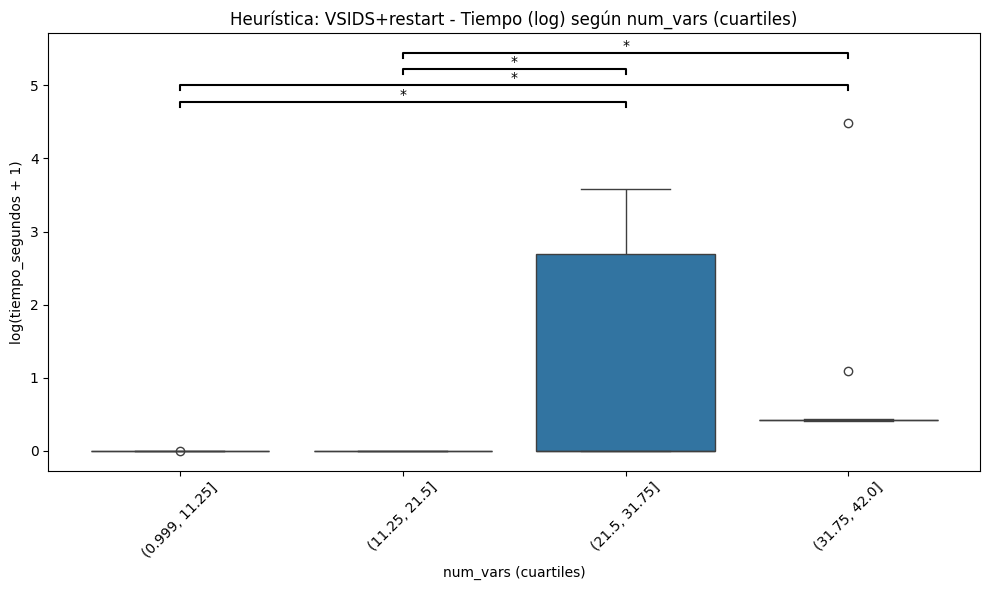

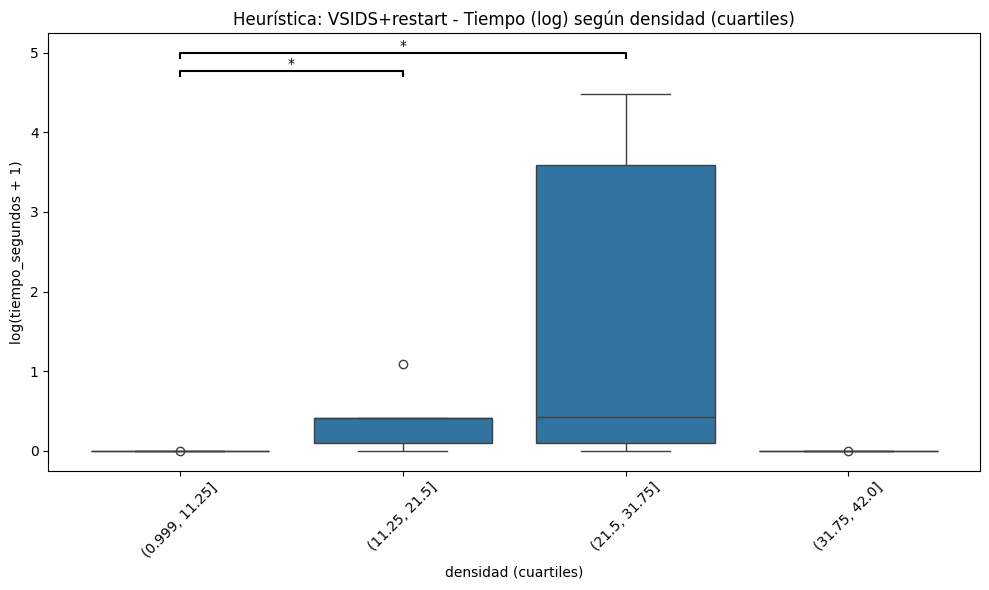

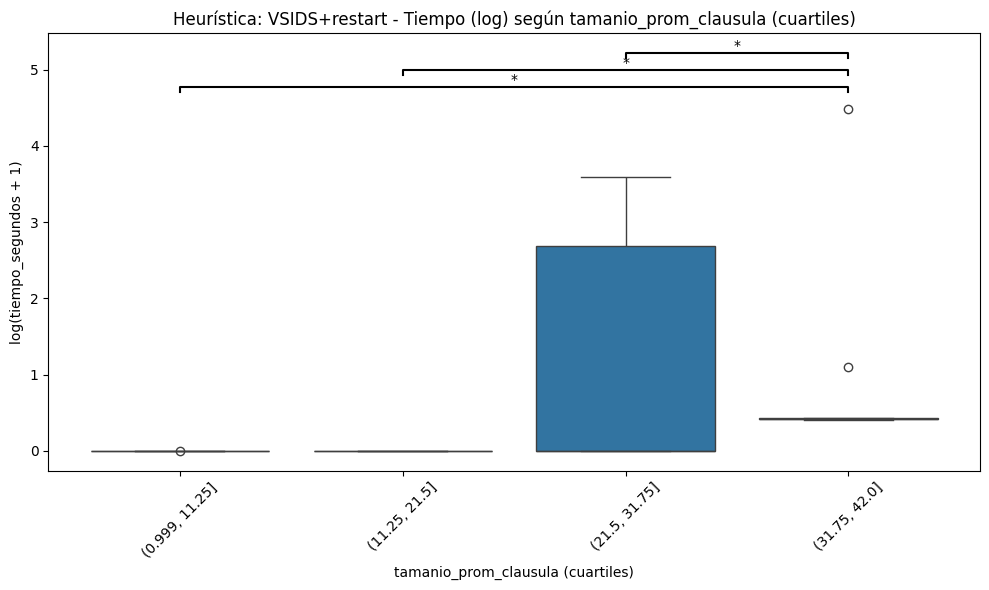

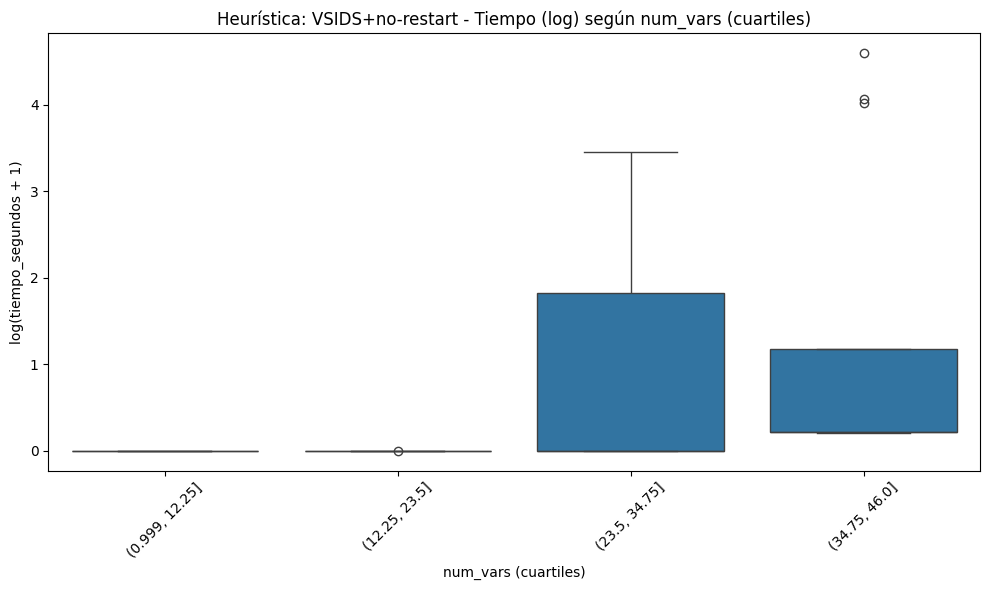

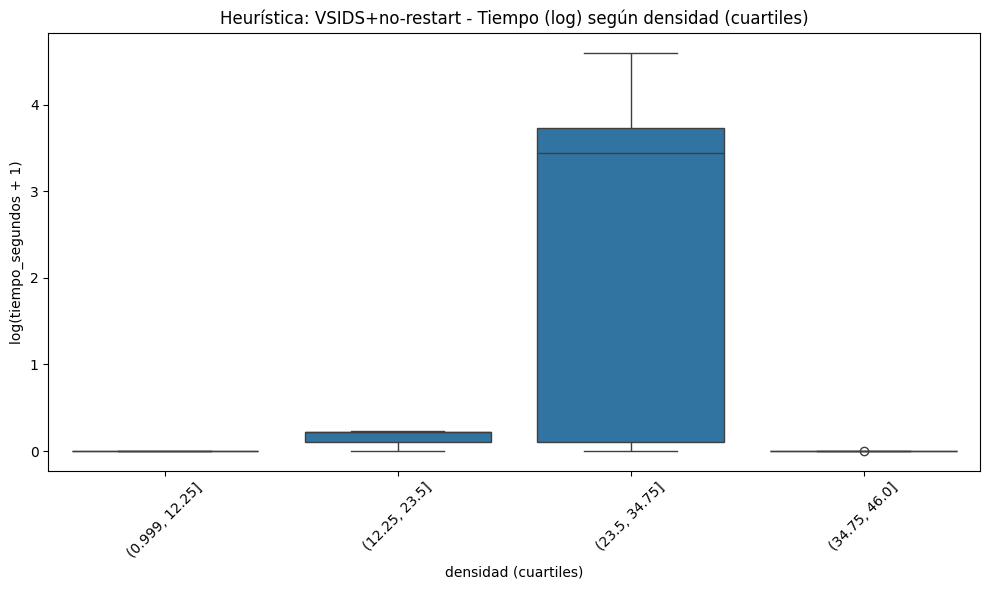

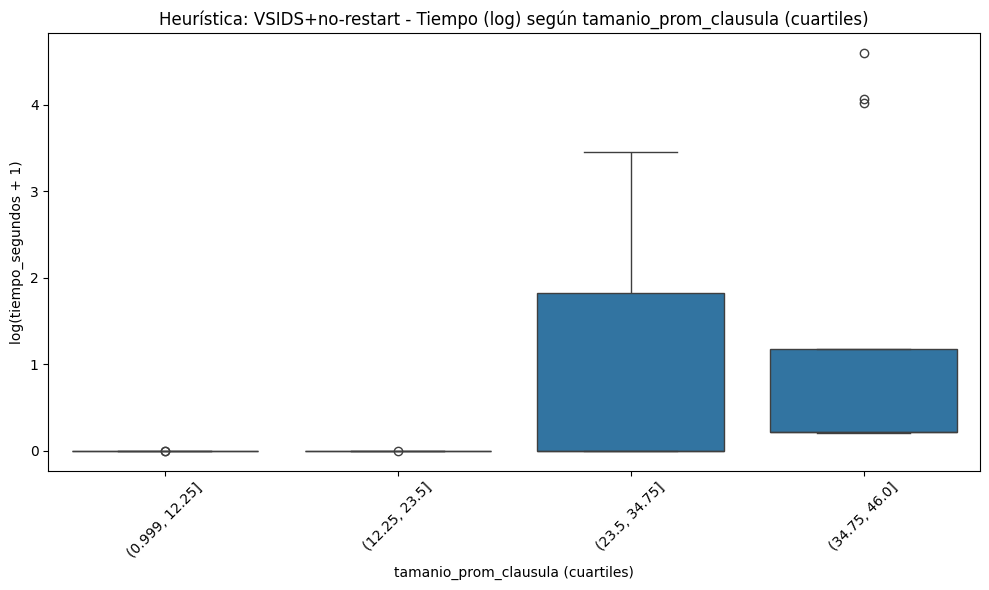

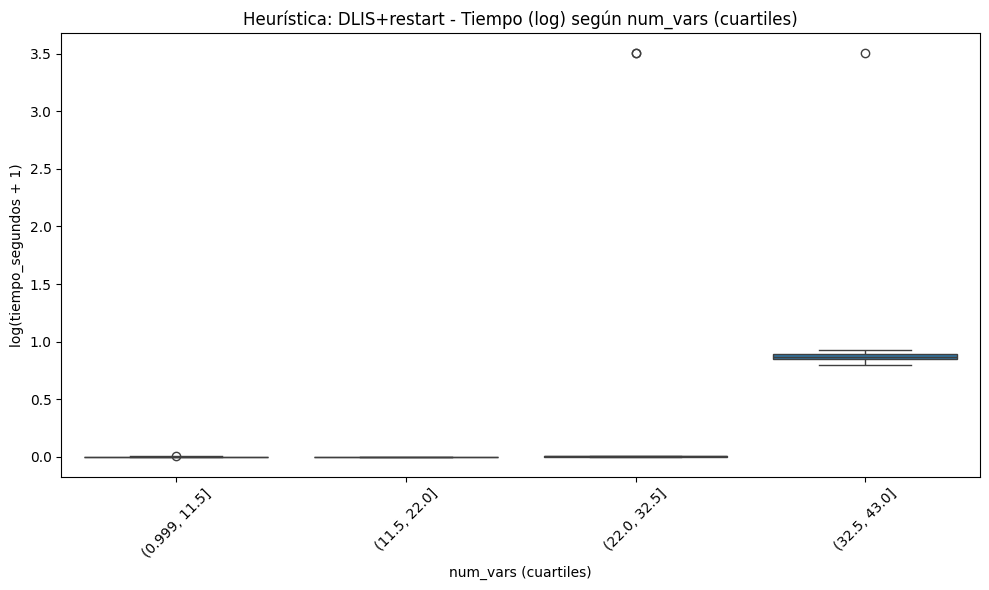

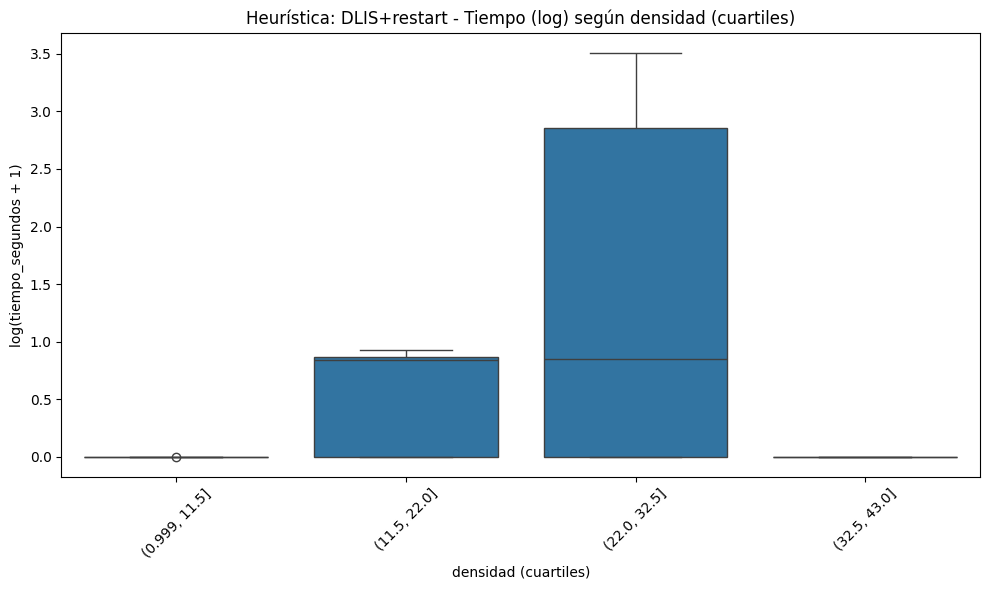

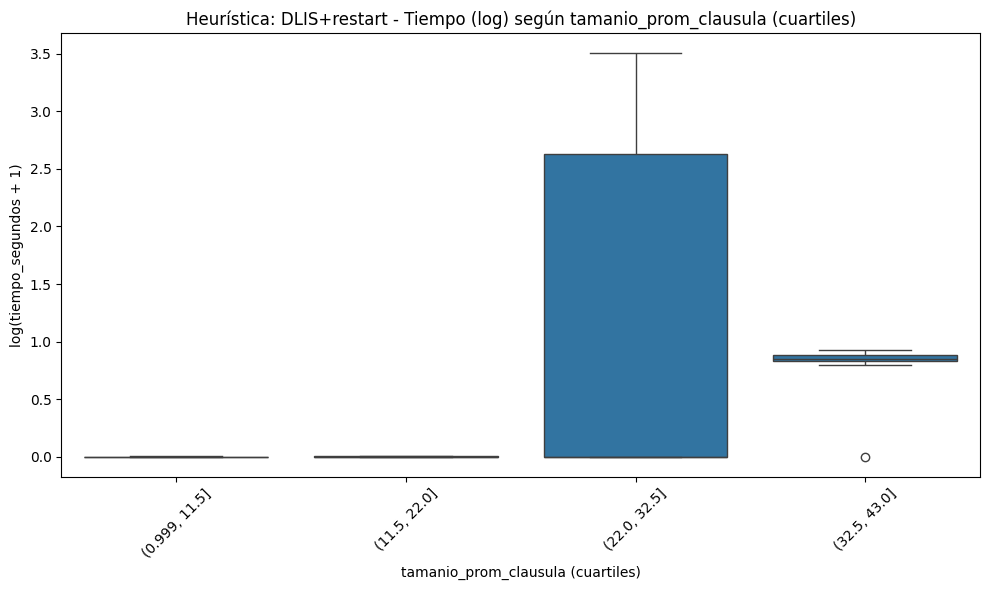

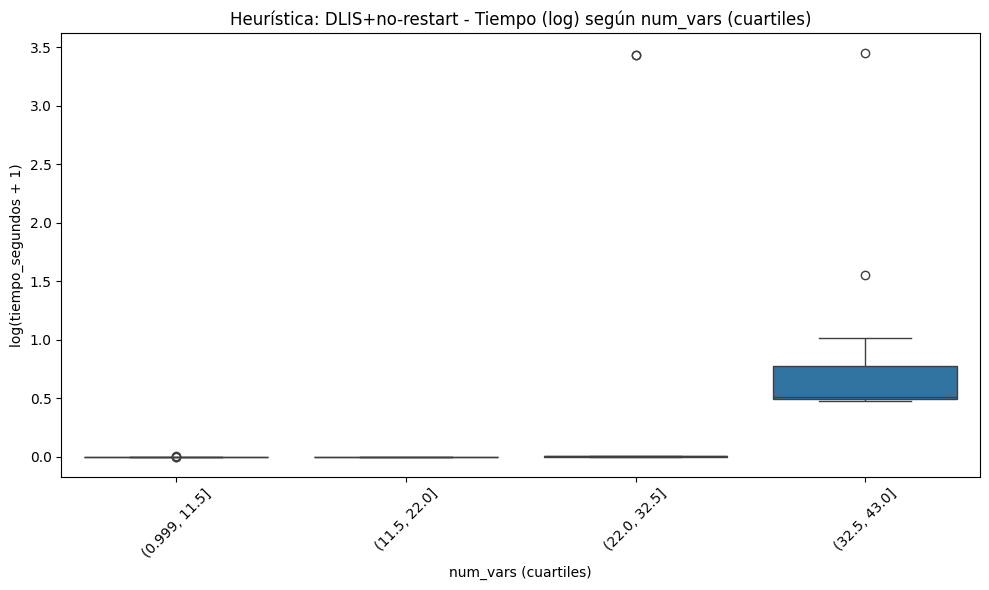

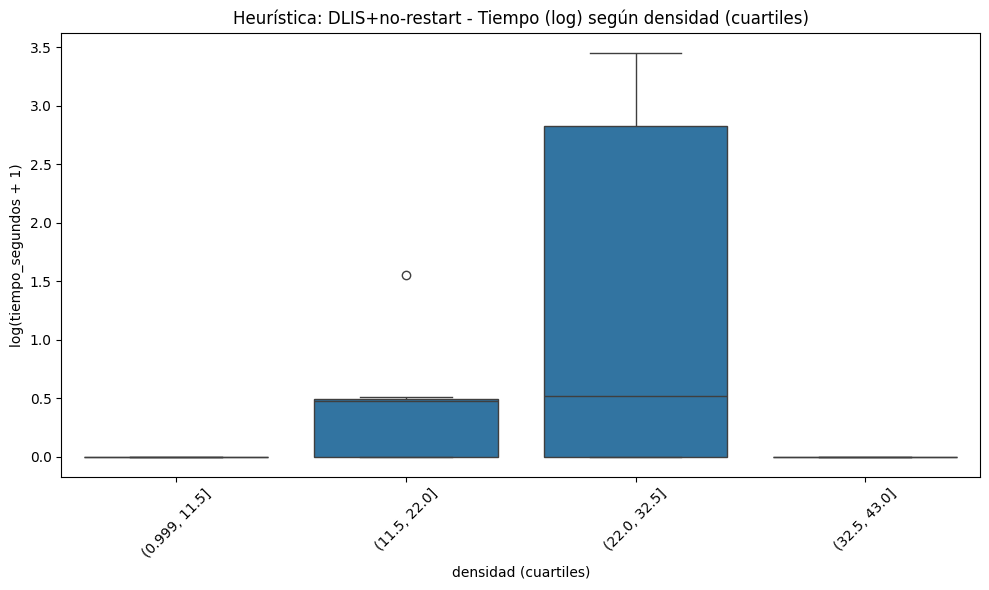

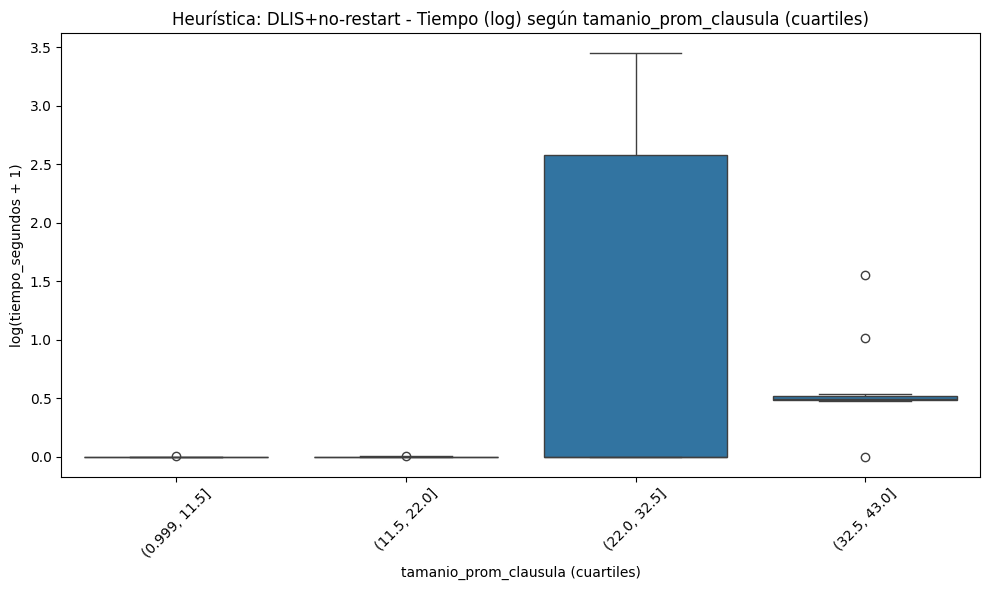

In [20]:
# Función para agregar líneas y asteriscos en comparaciones significativas
def add_stat_annotation(ax, group1, group2, y, h, text):
    x1, x2 = group1, group2
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color='k')

# Para cada heurística y variable, define los pares de grupos con p < 0.05

# Ejemplo simplificado para VSIDS+restart y variable num_vars
comparaciones_significativas = {
    'VSIDS+restart': {
        'num_vars': [(0, 2), (0, 3), (1, 2), (1, 3)],  # índices de grupos (0-based)
        'densidad': [(0, 1), (0, 2)],
        'tamanio_prom_clausula': [(0, 3), (1, 3), (2, 3)]
    },
    # Agrega las demás heurísticas y variables con sus pares significativos
}

for heuristica in df_solved_reduced['heuristica'].unique():
    df_h = df_solved_reduced[df_solved_reduced['heuristica'] == heuristica].copy()
    
    for var in caracteristicas_reducidas:
        # Discretizar variable en cuartiles con ranking para evitar warnings
        df_h.loc[:, 'grupo'] = pd.qcut(df_h[var].rank(method='first'), q=4, duplicates='drop')
        grupos_ordenados = sorted(df_h['grupo'].cat.categories)
        
        plt.figure(figsize=(10,6))
        ax = sns.boxplot(x='grupo', y='log_tiempo', data=df_h, order=grupos_ordenados)
        plt.title(f'Heurística: {heuristica} - Tiempo (log) según {var} (cuartiles)')
        plt.xlabel(f'{var} (cuartiles)')
        plt.ylabel('log(tiempo_segundos + 1)')
        plt.xticks(rotation=45)
        
        # Agregar anotaciones de comparaciones significativas si existen
        pares = comparaciones_significativas.get(heuristica, {}).get(var, [])
        y_max = df_h['log_tiempo'].max()
        h = (df_h['log_tiempo'].max() - df_h['log_tiempo'].min()) * 0.05  # altura para líneas
        
        for i, (g1, g2) in enumerate(pares):
            y = y_max + h * (i+1)
            add_stat_annotation(ax, g1, g2, y, h*0.3, '*')
        
        plt.tight_layout()
        plt.show()


### Visualización con boxplots o violín plots

/tmp/ipykernel_13319/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


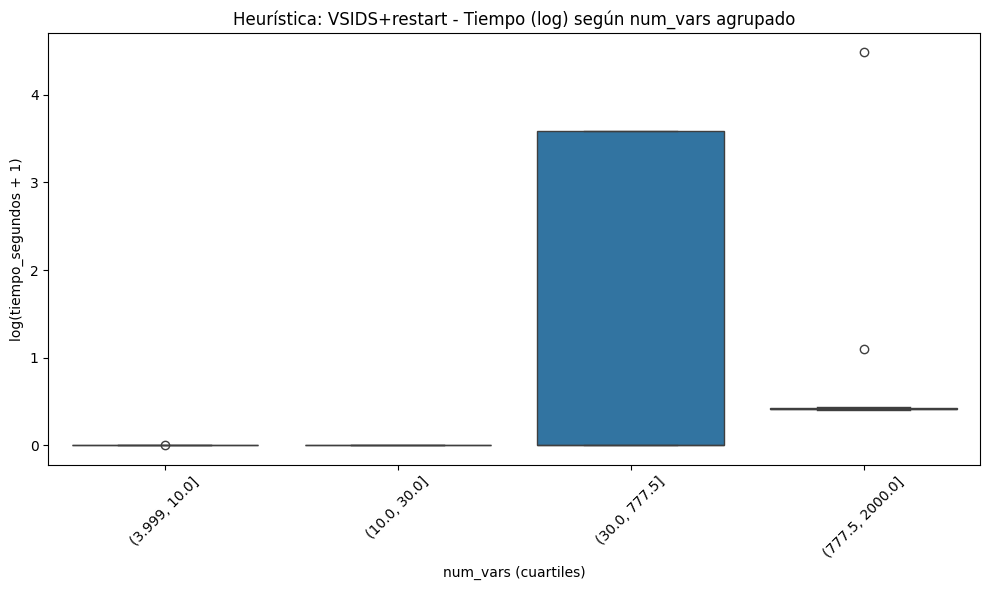

/tmp/ipykernel_13319/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


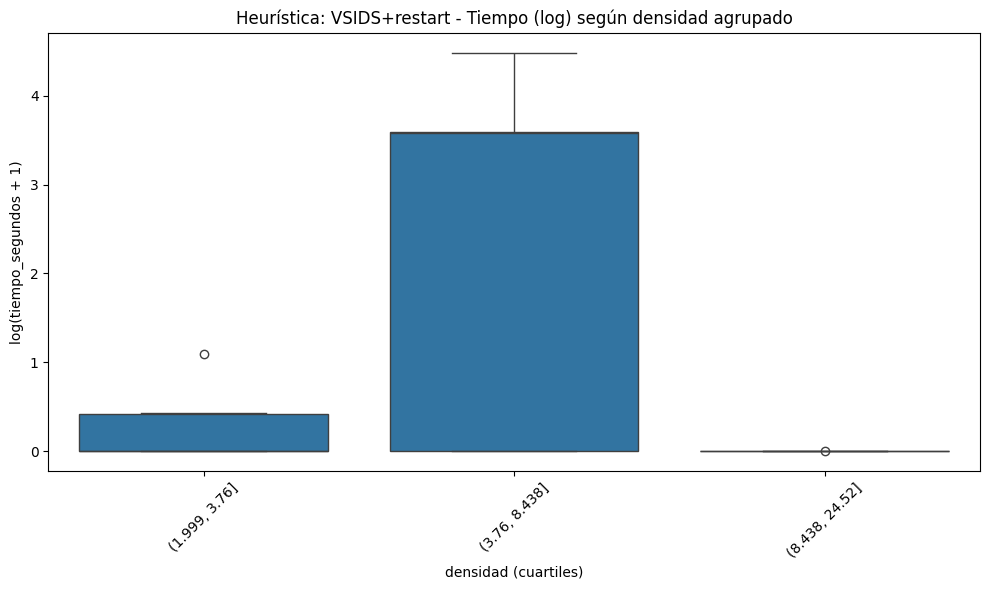

/tmp/ipykernel_13319/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


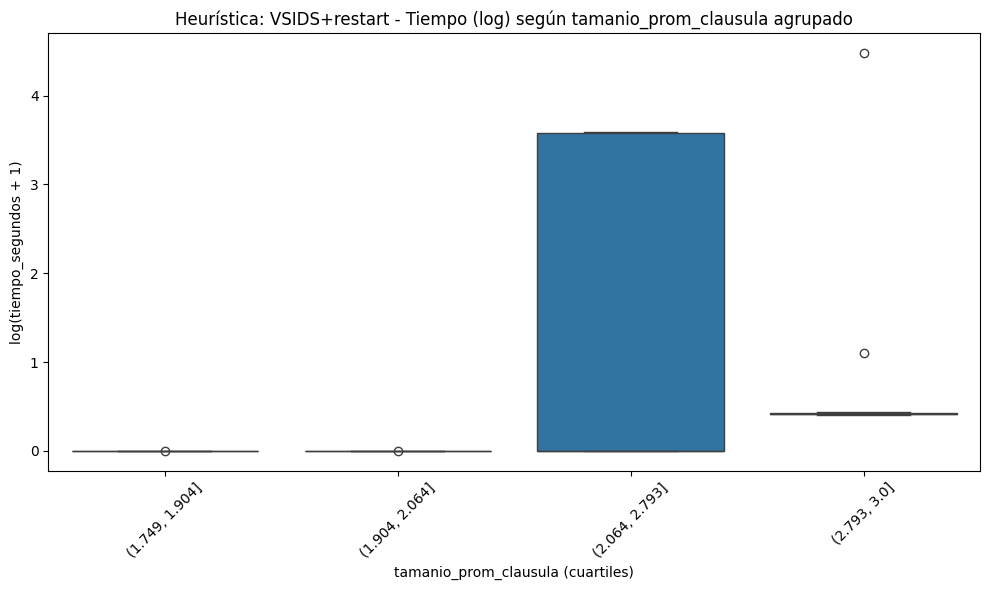

/tmp/ipykernel_13319/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


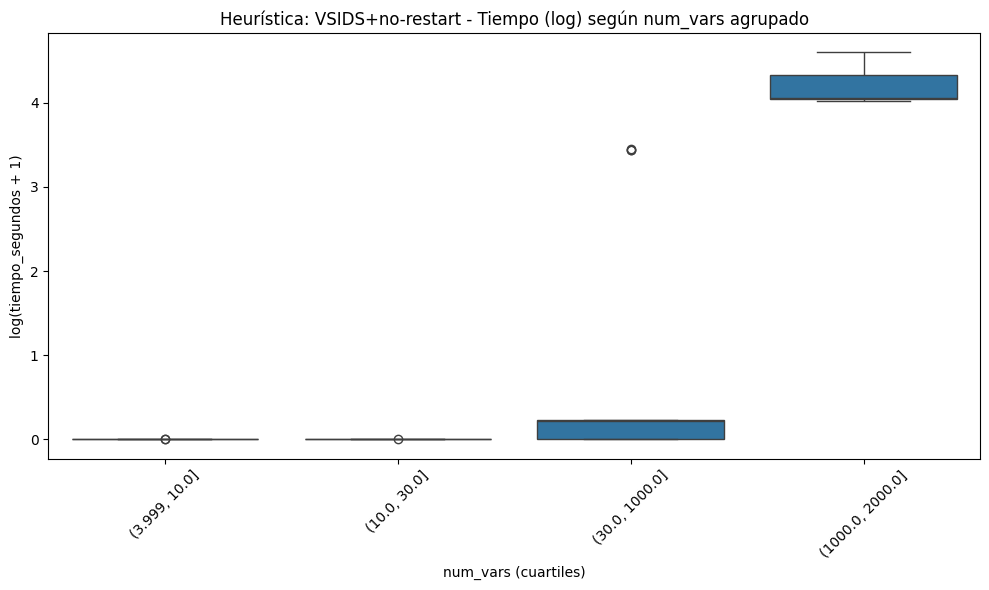

/tmp/ipykernel_13319/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


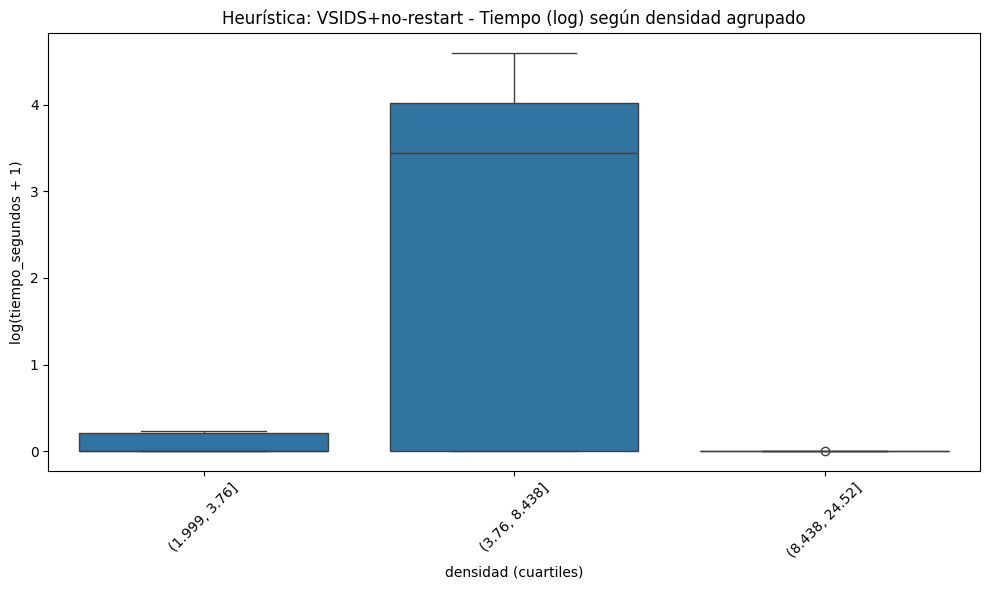

/tmp/ipykernel_13319/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


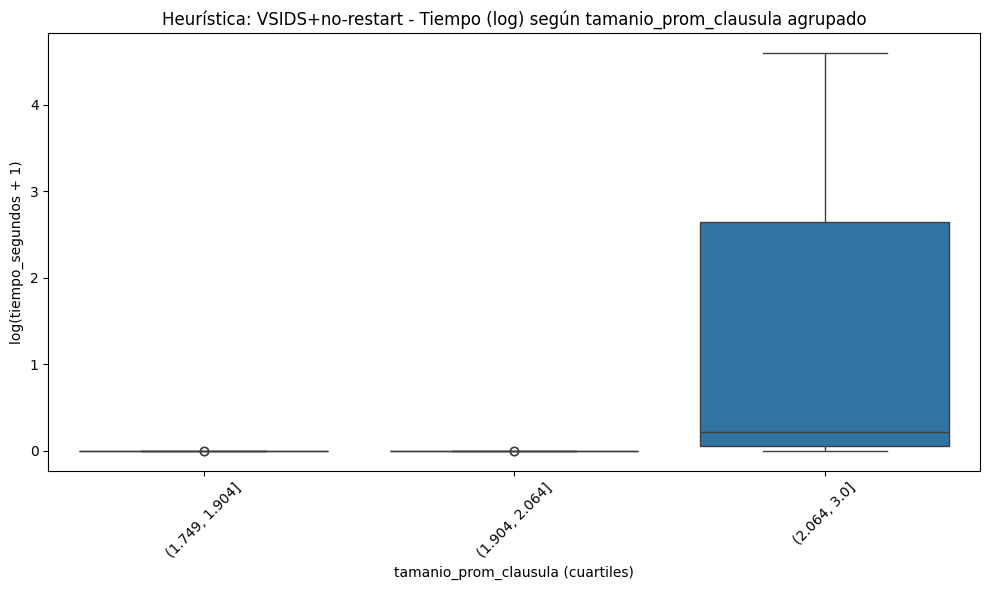

/tmp/ipykernel_13319/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


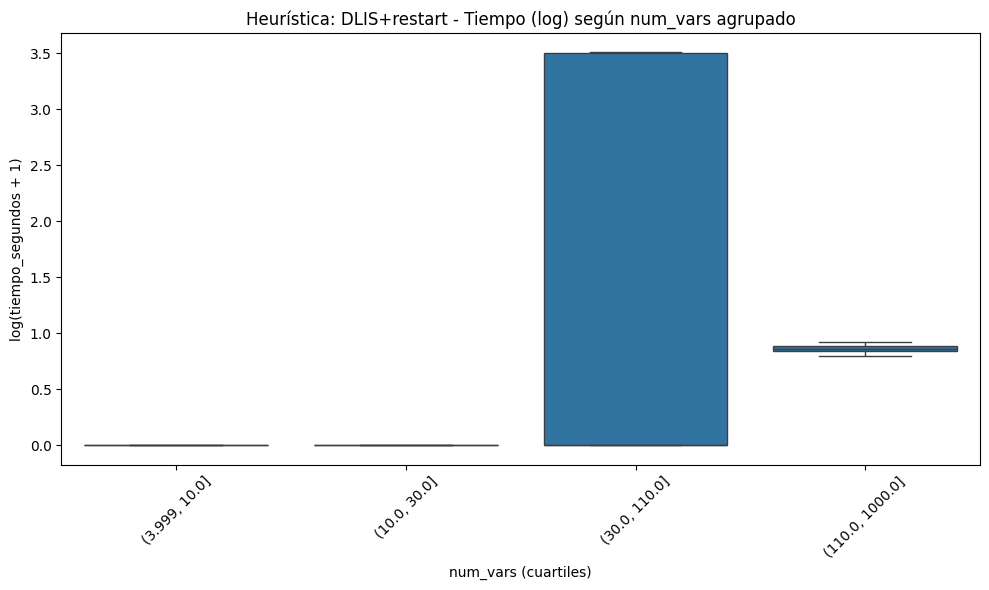

/tmp/ipykernel_13319/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


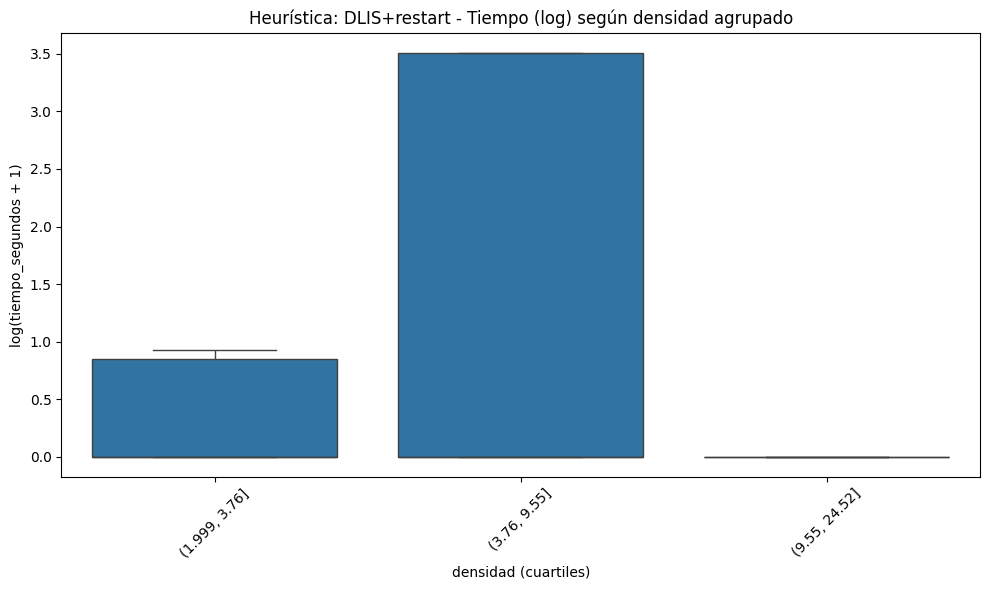

/tmp/ipykernel_13319/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


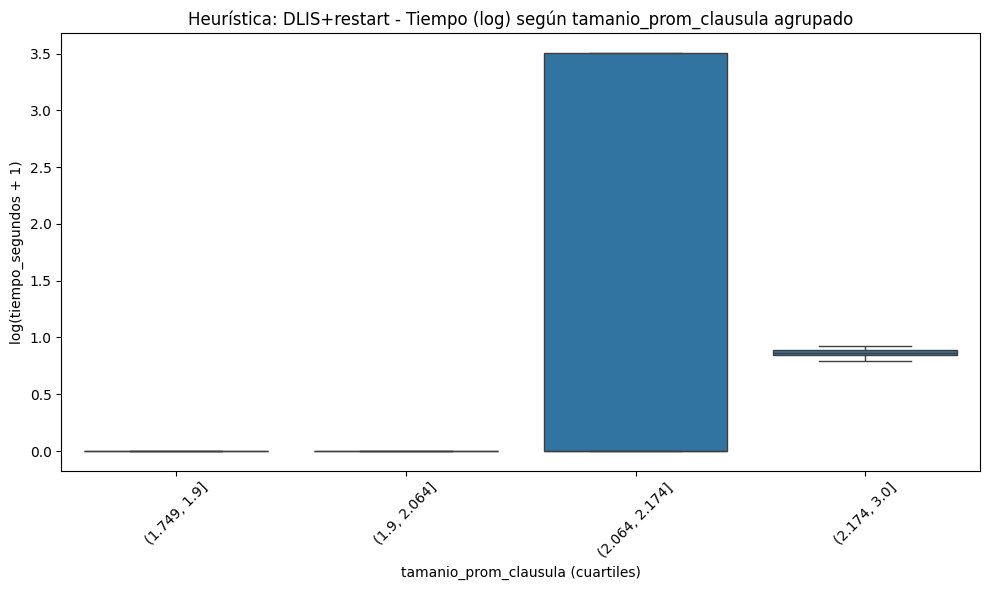

/tmp/ipykernel_13319/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


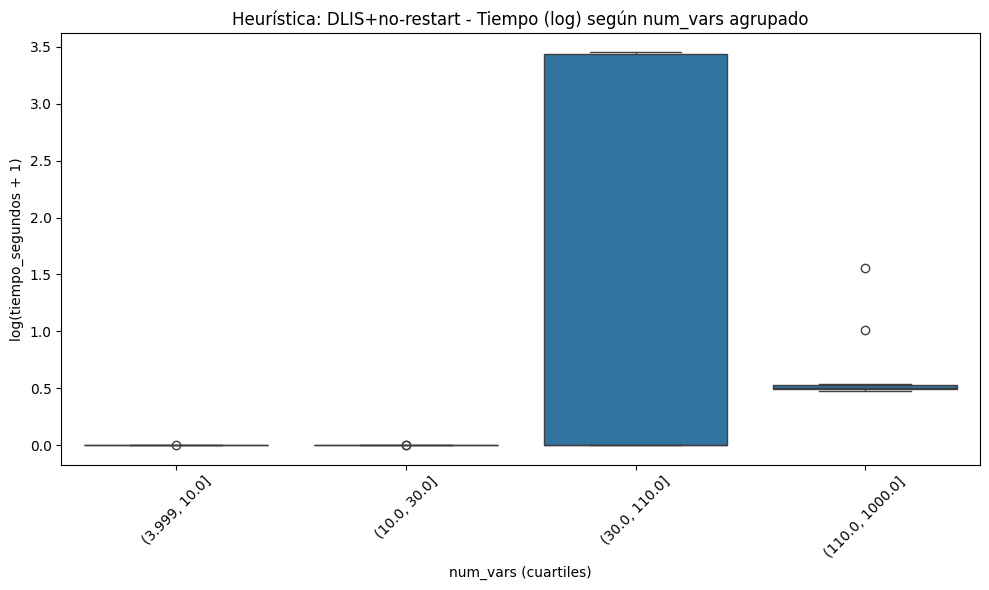

/tmp/ipykernel_13319/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


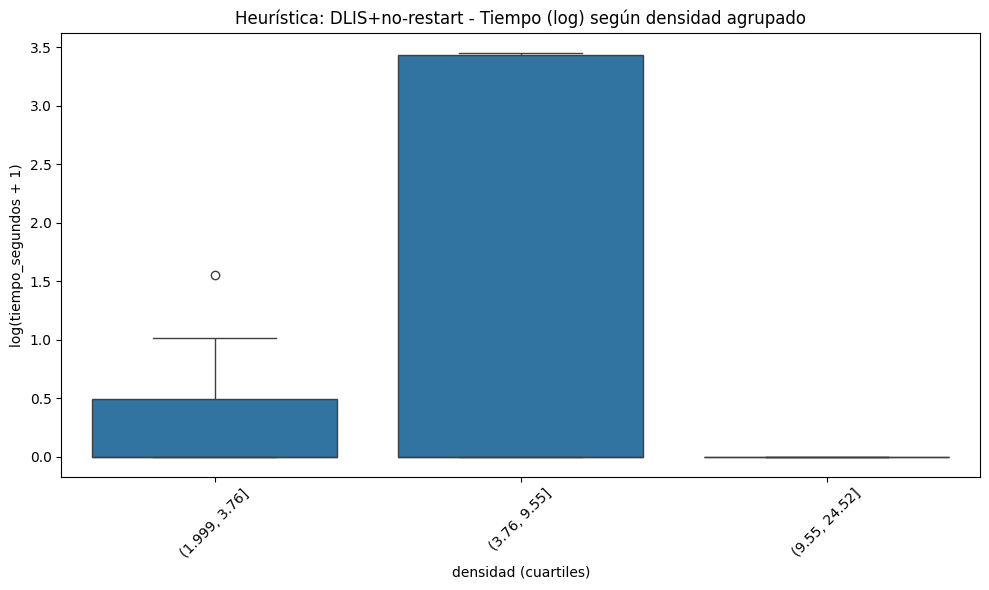

/tmp/ipykernel_13319/2625202799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')


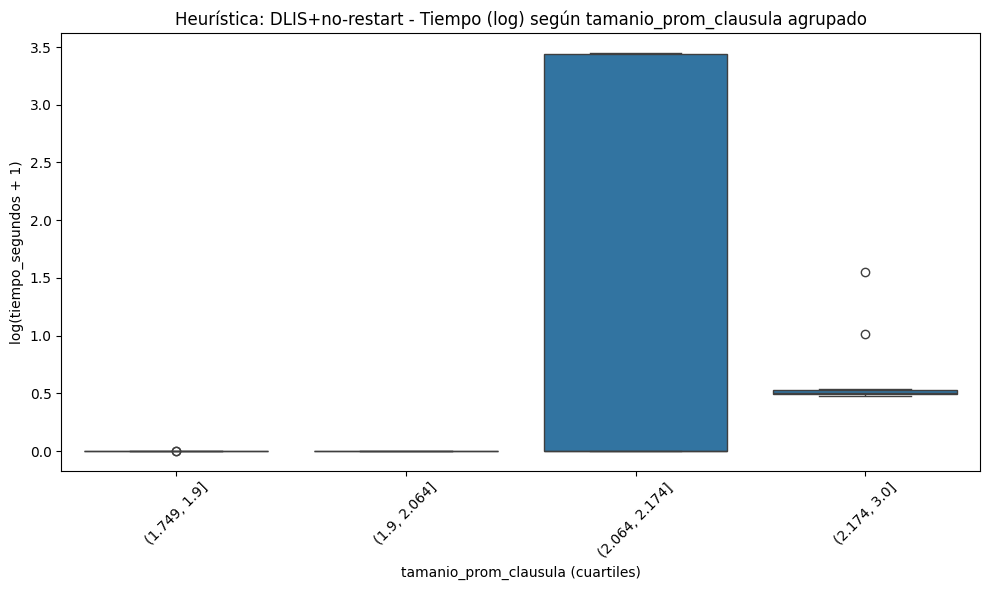

In [21]:

for heuristica in df_solved_reduced['heuristica'].unique():
    df_h = df_solved_reduced[df_solved_reduced['heuristica'] == heuristica]
    
    for var in caracteristicas_reducidas:
        # Discretizar variable en cuartiles para agrupar
        df_h['grupo'] = pd.qcut(df_h[var], q=4, duplicates='drop')
        
        plt.figure(figsize=(10,6))
        sns.boxplot(x='grupo', y='log_tiempo', data=df_h)
        # Alternativamente, usar sns.violinplot para ver distribución
        # sns.violinplot(x='grupo', y='log_tiempo', data=df_h)
        
        plt.title(f'Heurística: {heuristica} - Tiempo (log) según {var} agrupado')
        plt.xlabel(f'{var} (cuartiles)')
        plt.ylabel('log(tiempo_segundos + 1)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


#### c) Regresión lineal múltiple: ¿Qué características predicen el tiempo de resolución?
Los coeficientes y sus p-valores te indican qué características influyen más en el tiempo de resolución.

In [22]:
X = df_solved_reduced[caracteristicas_reducidas]
X = sm.add_constant(X)
y = df_solved_reduced['tiempo_segundos']

modelo = sm.OLS(y, X).fit()
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:        tiempo_segundos   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     33.59
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           4.22e-17
Time:                        15:34:09   Log-Likelihood:                -662.88
No. Observations:                 174   AIC:                             1334.
Df Residuals:                     170   BIC:                             1346.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    76.90

Este resultado corresponde a un modelo de regresión lineal múltiple (OLS) que busca explicar la variable dependiente tiempo_segundos a partir de tres variables predictoras: num_vars, densidad y tamanio_prom_clausula.

### Interpretación detallada
**Ajuste del modelo**

- R-cuadrado = 0.372: El modelo explica aproximadamente el 37.2% de la variabilidad total del tiempo de ejecución.

- R-cuadrado ajustado = 0.361: Ajusta el R² considerando el número de variables; sigue indicando un ajuste moderado.

- F-statistic (33.59) y p < 0.0001: El modelo en conjunto es estadísticamente significativo, es decir, al menos una variable predictora tiene efecto sobre el tiempo.

**Diagnósticos y advertencias**

- Omnibus y Jarque-Bera (p ~ 0): Indican que los residuos no siguen una distribución normal (asimetría y curtosis alta).

- Durbin-Watson = 1.198: Indica cierta autocorrelación positiva en residuos (ideal cercano a 2).

- Condición número alta (7.63e3): Puede indicar multicolinealidad o problemas numéricos, lo que afecta la estabilidad e interpretación de coeficientes.

### Conclusiones clave

El número de variables y el tamaño promedio de cláusula son predictores estadísticamente significativos del tiempo de ejecución, con efectos opuestos:

- Más variables → mayor tiempo.

- Cláusulas más grandes → menor tiempo (posible simplificación del problema).

La densidad no muestra un efecto significativo en este modelo ajustado.    Por otro lado, el modelo tiene un ajuste moderado y algunos problemas en supuestos (normalidad y autocorrelación de residuos, posible multicolinealidad) que deberían investigarse para mejorar la validez. La interpretación de coeficientes se hace controlando el efecto de las otras variables (coeficientes parciales).

(Tabla Variable-Coeficiente-Dignificancia...Interpretacionestadistica)

